## Imports

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [127]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import pandas as pd
import sklearn
from sklearn.datasets import load_breast_cancer

import pytorch_lightning as pl

from nam.data import *
from nam.config import *
from nam.models import NAM, DNN, get_num_units
from nam.trainer import *
from nam.utils.graphing import *

## Configuration 

In [128]:
config = defaults()
print(config)

Config(activation='exu', batch_size=1024, cross_val=False, data_split=1, debug=False, decay_rate=0.995, device='cpu', dropout=0.5, feature_dropout=0.0, fold_num=1, hidden_sizes=[64, 32], l2_regularization=0.0, lr=0.0003, n_folds=5, n_models=1, num_basis_functions=64, num_splits=3, num_units=64, num_workers=16, optimizer='adam', output_dir='output', output_regularization=0.0, patience=10, regression=True, seed=1377, shuffle=True, test_split=0.2, training_epochs=3, units_multiplier=2, use_dnn=False)


In [129]:
config.activation = "relu"
config.hidden_sizes=[64, 32]
# config.lr = 1e-3
# config.feature_dropout = 0.5
# config.l2_regularization = 0.5
# config.decay_rate = 0.999
# config.output_regularization = 0.5

In [130]:
# config.training_epochs = 10

In [131]:
dataset = load_sklearn_housing_data(config)

In [132]:
# dataset = load_gallup_data(config, 
#                            features_columns= ["income_2", "WP1219", "WP1220", "weo_gdpc_con_ppp"],
#                           weights_column=None)

In [133]:
# models = [NAM(
#   config=config,
#   name="NAMModel_GALLUP",
#   num_inputs=len(dataset[0][0]),
#   num_units=get_num_units(config, dataset.features),
# ) for _ in range(1)]
model = NAM(
  config=config,
  name="NAMModel_GALLUP",
  num_inputs=len(dataset[0][0]),
  num_units=get_num_units(config, dataset.features),
)
# model

In [134]:
config.training_epochs = 10

In [109]:
# for model in models:
#     trainer = Trainer(config, model, dataset)
#     trainer.train()
#     trainer.test()
trainer = Trainer(config, model, dataset)
trainer.train()
trainer.test()

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

In [136]:
litnam = LitNAM(config, model)
# engine

In [137]:
train_dl, val_dl, test_dl = dataset.get_dataloaders()

In [138]:
trainer = pl.Trainer(
    default_root_dir=f"{config.output_dir}/{model.name}",
    max_epochs=config.training_epochs,
)
trainer.fit(model=litnam, train_dataloader=train_dl, val_dataloaders=val_dl)

GPU available: False, used: False
TPU available: None, using: 0 TPU cores

  | Name  | Type | Params
-------------------------------
0 | model | NAM  | 51.0 K
-------------------------------
51.0 K    Trainable params
0         Non-trainable params
51.0 K    Total params
0.204     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

1

In [139]:
for litnam in litnams:
    trainer.test(model=litnam, test_dataloaders=test_dl)

NameError: name 'litnams' is not defined

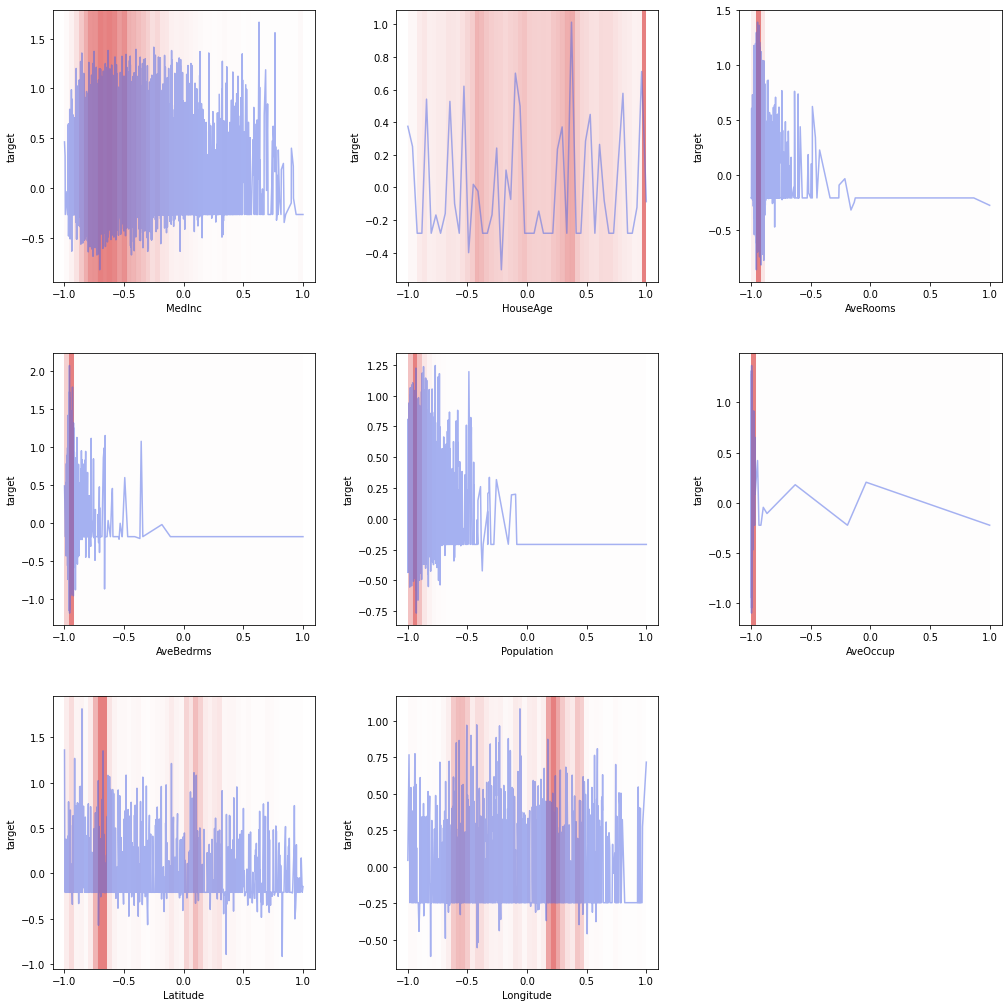

In [110]:
nam_plot(dataset, [model])

In [111]:
def get_feature_predictions(model: torch.nn.Module,
                              unique_features: torch.Tensor) -> Sequence[torch.Tensor]:
    feature_contributions = []
    for i, feature in enumerate(unique_features):
        feature_contributions.append(model.feature_nns[i](torch.tensor(feature).float()).detach().numpy().squeeze())

    return feature_contributions

In [112]:
get_feature_predictions(model, dataset.unique_features)[1]

array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.84246355,
        0.39227086,  0.09016335,  0.66499144,  0.12950394,  0.        ,
        0.15340246,  0.        ,  0.        ,  0.        ,  0.        ,
        0.36857778,  0.2914554 , -0.09206705,  0.        ,  0.12458323,
        0.11906621,  0.33858836,  0.20860699,  0.        ,  0.        ,
       -0.1297887 ,  0.        ,  1.1369027 ,  0.        ,  0.34634542,
        0.        ,  0.        ,  0.19934608,  0.        ,  0.38839996,
        0.2002962 ,  0.        , -0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.85623735,  0.44099018,
        0.99233526,  0.        ,  0.5945042 ,  0.4715321 , -0.01929707,
        0.        ,  0.        ], dtype=float32)

In [113]:
feature_predictions = get_feature_predictions(model, dataset.unique_features)

In [114]:
avg_hist_data = {col: predictions for col, predictions in zip(dataset.features_names, feature_predictions)}

In [115]:
avg_hist_data

{'MedInc': array([0.3681507 , 0.        , 0.10118786, ..., 0.8769195 , 0.71434784,
        0.        ], dtype=float32),
 'HouseAge': array([0.        , 0.24189195, 0.20368499, 0.        , 0.5718538 ,
        0.        , 0.        , 0.581664  , 0.8676921 , 0.        ,
        0.17769347, 0.406825  , 0.48105323, 0.        , 0.        ,
        1.0912517 , 0.        , 0.        , 0.        , 0.34977138,
        0.        , 0.        , 1.0219555 , 0.        , 0.199473  ,
        0.        , 0.22721547, 0.32626238, 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.8141161 ,
        0.529636  , 0.        , 0.53999925, 0.37377164, 0.        ,
        0.        , 0.        , 0.16678803, 0.5584185 , 0.        ,
        0.01901047, 0.5677729 , 0.3702881 , 0.6988953 , 0.2968863 ,
        0.4085914 , 0.28175017], dtype=float32),
 'AveRooms': array([0.5092827 , 0.        , 0.1607399 , ..., 0.        , 0.26234764,
        0.3651241 ], dtype=float32),
 'AveBedrms': arr

In [116]:
#@title Individual arrays for each Dataset feature

NUM_FEATURES = dataset.features.shape[-1]
# SINGLE_FEATURES = np.split(data_x, NUM_FEATURES, axis=1)
UNIQUE_FEATURES = dataset.unique_features #[np.unique(x, axis=0) for x in SINGLE_FEATURES]

SINGLE_FEATURES_ORIGINAL = dataset.sfo
UNIQUE_FEATURES_ORIGINAL = dataset.ufo

column_names = dataset.features_names

In [117]:
data_x = dataset.features
dataset_name = 'Housing'

In [118]:
#@title Calculate the mean prediction

ALL_INDICES = {}
MEAN_PRED = {}

for i, col in enumerate(column_names):
  x_i = dataset.features[:, i]
  ALL_INDICES[col] = np.searchsorted(UNIQUE_FEATURES[i][:, 0], x_i, 'left')
for col in column_names:
  MEAN_PRED[col] =  np.mean([avg_hist_data[col][i] for i in ALL_INDICES[col]])

print(MEAN_PRED)

{'MedInc': 0.2614143, 'HouseAge': 0.24326906, 'AveRooms': 0.20712228, 'AveBedrms': 0.16794227, 'Population': 0.2041344, 'AveOccup': 0.22831781, 'Latitude': 0.24747759, 'Longitude': 0.27523914}


In [119]:
#@title Helpers for MEAN feature importance

def compute_mean_feature_importance(avg_hist_data):
  mean_abs_score = {}
  for k in avg_hist_data:
        try:
            mean_abs_score[k] = np.mean(np.abs(avg_hist_data[k] - MEAN_PRED[k]))
        except: continue
  x1, x2 = zip(*mean_abs_score.items())
  return x1, x2

def plot_mean_feature_importance(x1, x2, width = 0.3):
  fig = plt.figure(figsize=(5, 4))
  ind = np.arange(len(x1))  # the x locations for the groups
  x1_indices = np.argsort(x2)
  cols_here = [cols[i] for i in x1_indices]
  # x1_here = [x12[i] for i in x1_indices]
  x2_here = [x2[i] for i in x1_indices]

  plt.bar(ind, x2_here, width, label='NAMs')
  # plt.bar(ind+width, x1_here, width, label='EBMs')
  plt.xticks(ind + width/2, cols_here, rotation=90, fontsize='large')
  plt.ylabel('Mean Absolute Score', fontsize='x-large')
  plt.legend(loc='upper right', fontsize='large')
  plt.title(f'Overall Importance: Housing', fontsize='x-large')
  plt.show()
  return fig

In [120]:
COL_NAMES = {}
COL_NAMES['Housing'] = {
    'MedInc': 'Median Income',
    'HouseAge': 'Median House Age',
    'AveRooms': '# Avg Rooms',
    'AveBedrms': '# Avg Bedrooms',
    'Population': 'Block Population',
    'AveOccup': '# Avg Occupancy',
    'Latitude': 'Latitude',
    'Longitude': 'Longitude'
  }

In [121]:
x1, x2 = compute_mean_feature_importance(avg_hist_data)

In [122]:
x1, x2

(('MedInc',
  'HouseAge',
  'AveRooms',
  'AveBedrms',
  'Population',
  'AveOccup',
  'Latitude',
  'Longitude'),
 (0.3094215,
  0.2465755,
  0.24301404,
  0.26607212,
  0.24520351,
  0.27658343,
  0.28928298,
  0.28168014))

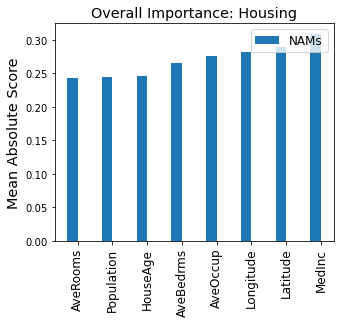

In [123]:
cols = column_names #[COL_NAMES["Housing"][x] for x in x1]
fig = plot_mean_feature_importance(x1, x2)

In [124]:
#@title Plotting Helper Functions

import matplotlib.pyplot as plt
import seaborn
import matplotlib.patches as patches

def shade_by_density_blocks(hist_data, num_rows, num_cols, 
                            n_blocks=5, color=[0.9, 0.5, 0.5], 
                            feature_to_use=None):
  hist_data_pairs = list(hist_data.items())
  hist_data_pairs.sort(key=lambda x: x[0])
  min_y = np.min([np.min(a[1]) for a in hist_data_pairs])
  max_y = np.max([np.max(a[1]) for a in hist_data_pairs])
  min_max_dif = max_y - min_y
  min_y = min_y - 0.01 * min_max_dif
  max_y = max_y + 0.01 * min_max_dif

  if feature_to_use:
    hist_data_pairs = [v for v in hist_data_pairs if v[0] in feature_to_use] 

  for i, (name, pred) in enumerate(hist_data_pairs):

    # unique_x_data, single_feature_data, pred = data
    unique_x_data = UNIQUE_FEATURES_ORIGINAL[name]
    single_feature_data = SINGLE_FEATURES_ORIGINAL[name]
    ax = plt.subplot(num_rows, num_cols, i+1)
    min_x = np.min(unique_x_data)
    max_x = np.max(unique_x_data)
    x_n_blocks = min(n_blocks, len(unique_x_data))
    if name in CATEGORICAL_NAMES:
      min_x -= 0.5
      max_x += 0.5
    segments = (max_x - min_x) / x_n_blocks
    density = np.histogram(single_feature_data, bins=x_n_blocks)
    normed_density = density[0] / np.max(density[0])
    rect_params = []
    for p in range(x_n_blocks):
      start_x = min_x + segments * p
      end_x = min_x + segments * (p + 1)
      # start_insert_index = min(
      #     max(0, np.searchsorted(density[1], start_x) - 1), x_n_blocks - 1)
      # end_insert_index = min(
      #     max(0, np.searchsorted(density[1], end_x) - 1), x_n_blocks - 1)
      # d = (normed_density[start_insert_index] + normed_density[end_insert_index])/2
      d = min(1.0, 0.01 + normed_density[p])
      rect_params.append((d, start_x, end_x))

    for param in rect_params:
      alpha, start_x, end_x = param 
      rect = patches.Rectangle((start_x, min_y - 1), end_x - start_x, 
                               max_y - min_y + 1, linewidth=0.01, 
                              edgecolor=color, facecolor=color, alpha=alpha)
      ax.add_patch(rect)


def plot_all_hist(hist_data, num_rows, num_cols,  color_base, 
                  linewidth=3.0, min_y=None, max_y=None, alpha=1.0, 
                  feature_to_use=None):
  hist_data_pairs = list(hist_data.items())
  hist_data_pairs.sort(key=lambda x: x[0])
  if min_y is None:
    min_y = np.min([np.min(a) for _, a in hist_data_pairs])
  if max_y is None:
    max_y = np.max([np.max(a) for _, a in hist_data_pairs])
  min_max_dif = max_y - min_y
  min_y = min_y - 0.01 * min_max_dif
  max_y = max_y + 0.01 * min_max_dif
  col_mapping = column_names #COL_NAMES[dataset_name]
  feature_mapping = FEATURE_LABEL_MAPPING[dataset_name] 

  total_mean_bias = 0

  if feature_to_use:
    hist_data_pairs = [v for v in hist_data_pairs if v[0] in feature_to_use] 
  
  for i, (name, pred) in enumerate(hist_data_pairs):
    mean_pred = MEAN_PRED[name] #np.mean(pred)
    total_mean_bias += mean_pred
    unique_x_data = UNIQUE_FEATURES_ORIGINAL[name]
    plt.subplot(num_rows, num_cols, i+1)

    if name in CATEGORICAL_NAMES:
      unique_x_data = np.round(unique_x_data, decimals=1)
      if len(unique_x_data) <= 2:
        step_loc = "mid"
      else:
        step_loc = "post"
      unique_plot_data = np.array(unique_x_data) - 0.5
      unique_plot_data[-1] += 1
      plt.step(unique_plot_data, pred - mean_pred, color=color_base, 
               linewidth=linewidth, where=step_loc, alpha=alpha)

      if name in feature_mapping:
        labels, rot = feature_mapping[name]
      else:
        labels = unique_x_data
        rot = None
      plt.xticks(unique_x_data, labels=labels, fontsize='x-large', rotation=rot)
    else:
      plt.plot(unique_x_data, pred - mean_pred, color=color_base, 
               linewidth=linewidth, alpha=alpha)
      plt.xticks(fontsize='x-large')
  
   
    plt.ylim(min_y, max_y)
    plt.yticks(fontsize='x-large')
    min_x = np.min(unique_x_data)
    max_x = np.max(unique_x_data)
    if name in CATEGORICAL_NAMES:
      min_x -= 0.5
      max_x += 0.5
    plt.xlim(min_x, max_x)
    if i % num_cols == 0:
      plt.ylabel('House Price Contribution', fontsize='x-large')
#     plt.xlabel(col_mapping[name], fontsize='x-large')
      plt.xlabel(name, fontsize='x-large')
  return min_y, max_y

/Users/amrmkayid/anaconda3/envs/nam/lib/python3.7/site-packages/ipykernel_launcher.py:26: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


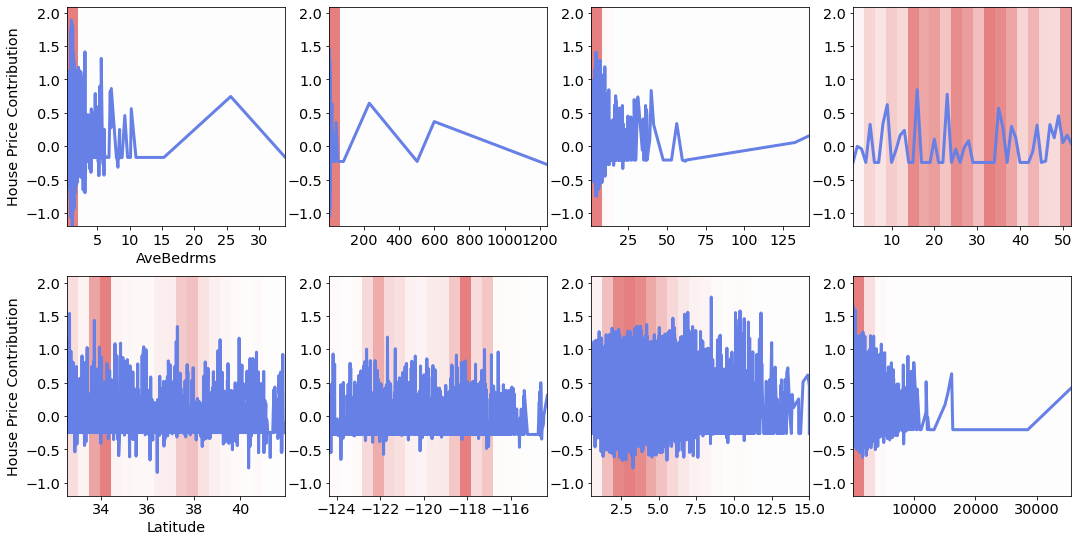

In [125]:
COLORS = [[0.9, 0.4, 0.5], [0.5, 0.9, 0.4], [0.4, 0.5, 0.9], [0.9, 0.5, 0.9]]
NUM_COLS =  4#@param {'type': 'integer'}
N_BLOCKS =  20#@param 

MIN_Y = None
MAX_Y = None


NUM_ROWS = int(np.ceil(NUM_FEATURES / NUM_COLS))
fig = plt.figure(num=None, figsize=(NUM_COLS * 4.5, NUM_ROWS * 4.5),
                 facecolor='w', edgecolor='k')

MIN_Y, MAX_Y = plot_all_hist(avg_hist_data, NUM_ROWS, NUM_COLS, COLORS[2],
                             min_y=MIN_Y, max_y=MAX_Y, feature_to_use=column_names)
shade_by_density_blocks(avg_hist_data, NUM_ROWS, NUM_COLS, n_blocks=N_BLOCKS, feature_to_use=column_names)

# This is for plotting individual plots when there are multiple models
"""
for pred in feature_predictions:
  model_hist = {col: pred[0, i] for i, col in enumerate(column_names)}
  plot_all_hist(model_hist, NUM_ROWS, NUM_COLS,
                color_base=[0.3, 0.4, 0.9, 0.2], alpha=0.06,
                linewidth=0.1, min_y=MIN_Y, max_y=MAX_Y, feature_to_use=features)
"""
plt.subplots_adjust(hspace=0.23)
plt.show()

In [50]:
CATEGORICAL_NAMES ={}
FEATURE_LABEL_MAPPING ={}
FEATURE_LABEL_MAPPING['Housing'] = {}

In [103]:
#@title Individual arrays for each Dataset feature

NUM_FEATURES = data_x.shape[1]
SINGLE_FEATURES = np.split(data_x, NUM_FEATURES, axis=1)
UNIQUE_FEATURES = [np.unique(x, axis=0) for x in SINGLE_FEATURES]

SINGLE_FEATURES_ORIGINAL = {}
UNIQUE_FEATURES_ORIGINAL = {}
for i, col in enumerate(column_names):
  min_val, max_val = col_min_max[col]
  UNIQUE_FEATURES_ORIGINAL[col] = inverse_min_max_scaler(
      UNIQUE_FEATURES[i][:, 0], min_val, max_val)
  SINGLE_FEATURES_ORIGINAL[col] = inverse_min_max_scaler(
      SINGLE_FEATURES[i][:, 0], min_val, max_val)

NameError: name 'data_x' is not defined

# Ray

In [21]:
from ray import tune

import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import pandas as pd
import sklearn
from sklearn.datasets import load_breast_cancer

import pytorch_lightning as pl

from nam.data import *
from nam.config import *
from nam.models import NAM, DNN, get_num_units
from nam.trainer import Trainer
from nam.utils.graphing import *

In [22]:
config = defaults()
print(config)

Config(activation='exu', batch_size=1024, cross_val=False, data_split=1, debug=False, decay_rate=0.995, device='cpu', dropout=0.5, feature_dropout=0.0, fold_num=1, hidden_sizes=[64, 32], l2_regularization=0.0, lr=0.0003, n_folds=5, n_models=1, num_basis_functions=64, num_splits=3, num_units=64, num_workers=16, optimizer='adam', output_dir='output', output_regularization=0.0, patience=10, regression=True, seed=1377, shuffle=True, test_split=0.2, training_epochs=3, units_multiplier=2, use_dnn=False)


In [23]:
def tune_trainer(cfg):
    config.update(**cfg)
    print(config)
    dataset = load_sklearn_housing_data(config)
    
    model = NAM(
      config=config,
      name="NAMModel_GALLUP",
      num_inputs=len(dataset[0][0]),
      num_units=get_num_units(config, dataset.features),
    )
    
    trainer = Trainer(config, model, dataset)
    trainer.train()
    trainer.test()
    
    nam_plot(dataset, [model])

In [24]:
analysis = tune.run(
    tune_trainer,
    config={
#         "activation": tune.choice(["exu", "relu"]),
#         "batch_size": tune.grid_search([512, 1024, 2048]),
# #         "decay_rate": tune.grid_search([0.0, 0.9, 0.995]),
#         "dropout": tune.grid_search([0.0, 0.5, 0.95]),
#         "feature_dropout": tune.grid_search([0.0, 0.5, 0.95]),
#         "l2_regularization": tune.grid_search([0.0, 0.5, 0.95]),
#         "output_regularization": tune.grid_search([0.0, 0.5, 0.95]),
        "lr": tune.grid_search([0.1, 0.01, 1e-3, 3e-4]),
#         "hidden_sizes": tune.choice([[], [32], [64, 32, 32]])
    }
)

Trial name,status,loc,lr
tune_trainer_ddaba_00000,RUNNING,,0.1


(pid=51140) Config(activation='exu', batch_size=1024, cross_val=False, data_split=1, debug=False, decay_rate=0.995, device='cpu', dropout=0.5, feature_dropout=0.0, fold_num=1, hidden_sizes=[64, 32], l2_regularization=0.0, lr=0.01, n_folds=5, n_models=1, num_basis_functions=64, num_splits=3, num_units=64, num_workers=16, optimizer='adam', output_dir='output', output_regularization=0.0, patience=10, regression=True, seed=1377, shuffle=True, test_split=0.2, training_epochs=3, units_multiplier=2, use_dnn=False)
(pid=51139) Config(activation='exu', batch_size=1024, cross_val=False, data_split=1, debug=False, decay_rate=0.995, device='cpu', dropout=0.5, feature_dropout=0.0, fold_num=1, hidden_sizes=[64, 32], l2_regularization=0.0, lr=0.1, n_folds=5, n_models=1, num_basis_functions=64, num_splits=3, num_units=64, num_workers=16, optimizer='adam', output_dir='output', output_regularization=0.0, patience=10, regression=True, seed=1377, shuffle=True, test_split=0.2, training_epochs=3, units_mult

(pid=51140) /Users/amrmkayid/anaconda3/envs/nam/lib/python3.7/site-packages/torch/nn/init.py:162: UserWarning: mean is more than 2 std from [a, b] in nn.init.trunc_normal_. The distribution of values may be incorrect.
(pid=51140)   return _no_grad_trunc_normal_(tensor, mean, std, a, b)
  0%|          | 0/15 [00:00<?, ?it/s]
(pid=51139) /Users/amrmkayid/anaconda3/envs/nam/lib/python3.7/site-packages/torch/nn/init.py:162: UserWarning: mean is more than 2 std from [a, b] in nn.init.trunc_normal_. The distribution of values may be incorrect.
(pid=51139)   return _no_grad_trunc_normal_(tensor, mean, std, a, b)
  0%|          | 0/15 [00:00<?, ?it/s]
(pid=51140) 
TL Step: 10.287 | MAE: 2.617:   0%|          | 0/15 [00:00<?, ?it/s]
TL Step: 10.287 | MAE: 2.617:   7%|▋         | 1/15 [00:00<00:08,  1.63it/s]
(pid=51139) 
TL Step: 7.047 | MAE: 2.107:   0%|          | 0/15 [00:00<?, ?it/s]
TL Step: 7.047 | MAE: 2.107:   7%|▋         | 1/15 [00:00<00:08,  1.65it/s]
(pid=51140) 
TL Step: 39.658 | M

Result for tune_trainer_ddaba_00000:
  date: 2021-04-11_17-45-00
  done: false
  experiment_id: 9deaaeecbeae4aec92d84496bb2852b5
  hostname: KayidmacOS
  iterations_since_restore: 1
  loss_train: tensor(658.5598, requires_grad=True)
  metrics_train: 9.51981688340505
  node_ip: 192.168.1.12
  pid: 51139
  time_since_restore: 1.1132049560546875
  time_this_iter_s: 1.1132049560546875
  time_total_s: 1.1132049560546875
  timestamp: 1618155900
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: ddaba_00000
  
Result for tune_trainer_ddaba_00001:
  date: 2021-04-11_17-45-00
  done: false
  experiment_id: 241484eed285469cb111c871cb46cbce
  hostname: KayidmacOS
  iterations_since_restore: 1
  loss_train: tensor(6.7137, requires_grad=True)
  metrics_train: 1.8750179449717204
  node_ip: 192.168.1.12
  pid: 51140
  time_since_restore: 1.1150791645050049
  time_this_iter_s: 1.1150791645050049
  time_total_s: 1.1150791645050049
  timestamp: 1618155900
  timesteps_since_restore: 0
  tra

(pid=51140) 
VL Step: 2.205 | MAE: 1.163:   0%|          | 0/2 [00:00<?, ?it/s]
VL Step: 2.419 | MAE: 1.208:   0%|          | 0/2 [00:00<?, ?it/s]
(pid=51139) 
VL Step: 4.330 | MAE: 1.657:   0%|          | 0/2 [00:00<?, ?it/s]
VL Step: 4.740 | MAE: 1.736: 100%|██████████| 2/2 [00:00<00:00, 14.98it/s]
Epoch(0): TL: 658.560 | VL: 4.535 | Metrics: 9.520:  33%|███▎      | 1/3 [00:01<00:02,  1.16s/it]
(pid=51139) 
  0%|          | 0/15 [00:00<?, ?it/s]
VL Step: 2.419 | MAE: 1.208: 100%|██████████| 2/2 [00:00<00:00, 14.81it/s]
Epoch(0): TL: 6.714 | VL: 2.312 | Metrics: 1.875:  33%|███▎      | 1/3 [00:01<00:02,  1.17s/it]
  0%|          | 0/15 [00:00<?, ?it/s]
(pid=51140) 
TL Step: 2.193 | MAE: 1.157:   0%|          | 0/15 [00:00<?, ?it/s]
TL Step: 2.193 | MAE: 1.157:   7%|▋         | 1/15 [00:00<00:02,  6.74it/s]
TL Step: 2.099 | MAE: 1.121:   7%|▋         | 1/15 [00:00<00:02,  6.74it/s]
(pid=51139) 
TL Step: 4.792 | MAE: 1.752:   0%|          | 0/15 [00:00<?, ?it/s]
TL Step: 4.792 | MAE: 1.

Trial name,status,loc,lr,iter,total time (s),metrics_train
tune_trainer_ddaba_00000,RUNNING,192.168.1.12:51139,0.1,2,1.77302,1.39259
tune_trainer_ddaba_00001,RUNNING,192.168.1.12:51140,0.01,3,2.55519,1.05076


TL Step: 1.713 | MAE: 1.003: 100%|██████████| 15/15 [00:00<00:00, 24.93it/s]
(pid=51140) 
  0%|          | 0/2 [00:00<?, ?it/s]
TL Step: 2.156 | MAE: 1.121: 100%|██████████| 15/15 [00:00<00:00, 24.30it/s]
(pid=51139) 
  0%|          | 0/2 [00:00<?, ?it/s]
(pid=51140) 
VL Step: 1.936 | MAE: 1.051:   0%|          | 0/2 [00:00<?, ?it/s]
VL Step: 1.804 | MAE: 1.029:   0%|          | 0/2 [00:00<?, ?it/s]
(pid=51139) 
VL Step: 2.353 | MAE: 1.163:   0%|          | 0/2 [00:00<?, ?it/s]
(pid=51139) 
VL Step: 2.199 | MAE: 1.123:   0%|          | 0/2 [00:00<?, ?it/s]
VL Step: 2.199 | MAE: 1.123: 100%|██████████| 2/2 [00:00<00:00, 19.09it/s]
VL Step: 1.804 | MAE: 1.029: 100%|██████████| 2/2 [00:00<00:00, 14.84it/s]
Epoch(2): TL: 1.893 | VL: 1.870 | Metrics: 1.051: 100%|██████████| 3/3 [00:02<00:00,  1.15it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
VL Step: 2.199 | MAE: 1.123: 100%|██████████| 2/2 [00:00<00:00, 13.68it/s]
Epoch(2): TL: 2.390 | VL: 2.276 | Metrics: 1.181: 100%|██████████| 3/3 [00:02<

Result for tune_trainer_ddaba_00001:
  date: 2021-04-11_17-45-02
  done: true
  experiment_id: 241484eed285469cb111c871cb46cbce
  experiment_tag: 1_lr=0.01
  hostname: KayidmacOS
  iterations_since_restore: 6
  loss_test: 1.7194799184799194
  node_ip: 192.168.1.12
  pid: 51140
  time_since_restore: 3.2712931632995605
  time_this_iter_s: 0.20397424697875977
  time_total_s: 3.2712931632995605
  timestamp: 1618155902
  timesteps_since_restore: 0
  training_iteration: 6
  trial_id: ddaba_00001
  
Result for tune_trainer_ddaba_00000:
  date: 2021-04-11_17-45-02
  done: true
  experiment_id: 9deaaeecbeae4aec92d84496bb2852b5
  experiment_tag: 0_lr=0.1
  hostname: KayidmacOS
  iterations_since_restore: 6
  loss_test: 2.2751822471618652
  node_ip: 192.168.1.12
  pid: 51139
  time_since_restore: 3.270829916000366
  time_this_iter_s: 0.19970083236694336
  time_total_s: 3.270829916000366
  timestamp: 1618155902
  timesteps_since_restore: 0
  training_iteration: 6
  trial_id: ddaba_00000
  


Trial name,status,loc,lr,iter,total time (s),loss_test
tune_trainer_ddaba_00000,TERMINATED,,0.1,6,3.27083,2.27518
tune_trainer_ddaba_00001,TERMINATED,,0.01,6,3.27129,1.71948


2021-04-11 17:45:03,457	INFO tune.py:450 -- Total run time: 6.72 seconds (6.71 seconds for the tuning loop).


In [25]:
print("Best config: ", analysis.get_best_config(
    metric="loss_test", mode="min"))

Best config:  {'lr': 0.01}


In [14]:
df = analysis.results_df
df

,loss_test,time_this_iter_s,done,timesteps_total,episodes_total,training_iteration,experiment_id,date,timestamp,time_total_s,...,node_ip,time_since_restore,timesteps_since_restore,iterations_since_restore,experiment_tag,config.activation,config.batch_size,config.dropout,config.lr,config.hidden_sizes
trial_id,,,,,,,,,,,,,,,,,,,,,
52f96_00000,0.697323,0.742134,True,None,None,6,337798f651f14ce28000630963519f37,2021-04-11_17-41-23,1618155683,14.909354,...,192.168.1.12,14.909354,0,6,"0_activation=relu,batch_size=512,dropout=0.0,h...",relu,512,0.00,0.1000,[32]
52f96_00001,0.645211,0.541346,True,None,None,6,21d503cd0ae4497cb549779afce4e6c9,2021-04-11_17-41-18,1618155678,9.844030,...,192.168.1.12,9.844030,0,6,"1_activation=relu,batch_size=1024,dropout=0.0,...",relu,1024,0.00,0.1000,[]
52f96_00002,1.231391,1.489183,True,None,None,6,5da818bec2754caeb8f713fb0c57f8ad,2021-04-11_17-41-25,1618155685,17.275118,...,192.168.1.12,17.275118,0,6,"2_activation=exu,batch_size=2048,dropout=0.0,h...",exu,2048,0.00,0.1000,"[64, 32, 32]"
52f96_00003,1.692484,0.735054,True,None,None,6,d75a3bcfe0d44a6981ca535504394b77,2021-04-11_17-41-24,1618155684,16.097067,...,192.168.1.12,16.097067,0,6,"3_activation=relu,batch_size=512,dropout=0.5,h...",relu,512,0.50,0.1000,[32]
52f96_00004,2.199503,0.845216,True,None,None,6,577da2514d43404982d8b25e95c71048,2021-04-11_17-41-26,1618155686,16.316560,...,192.168.1.12,16.316560,0,6,"4_activation=exu,batch_size=1024,dropout=0.5,h...",exu,1024,0.50,0.1000,[32]
52f96_00005,2.859664,0.651375,True,None,None,6,f0b5a0fe3d1d4ba3918c7910df38d83c,2021-04-11_17-41-30,1618155690,19.610367,...,192.168.1.12,19.610367,0,6,"5_activation=exu,batch_size=2048,dropout=0.5,h...",exu,2048,0.50,0.1000,"[64, 32, 32]"
52f96_00006,4.642832,0.353402,True,None,None,6,9c04e823ef5642d3b576cc200c1a3101,2021-04-11_17-41-31,1618155691,21.576937,...,192.168.1.12,21.576937,0,6,"6_activation=exu,batch_size=512,dropout=0.95,h...",exu,512,0.95,0.1000,"[64, 32, 32]"
52f96_00007,4.065288,0.665333,True,None,None,6,697467e2b12a4a7bba53082450ece2e9,2021-04-11_17-41-24,1618155684,13.758389,...,192.168.1.12,13.758389,0,6,"7_activation=exu,batch_size=1024,dropout=0.95,...",exu,1024,0.95,0.1000,[]
52f96_00008,2.830920,1.400727,True,None,None,6,42b5f9f8e852433bb166db022d61fbde,2021-04-11_17-41-27,1618155687,16.878663,...,192.168.1.12,16.878663,0,6,"8_activation=relu,batch_size=2048,dropout=0.95...",relu,2048,0.95,0.1000,[32]


In [12]:
import time
import tqdm

In [16]:
l = ['a', 'b', 'c'] 

In [17]:
with tqdm.tqdm(l) as pbar_epoch:
    for letter in pbar_epoch:
        for i2 in tqdm.tqdm(range(10), leave=False):
            pbar_epoch.set_description(f"Letter: {letter}")
            time.sleep(0.01)


  0%|          | 0/3 [00:00<?, ?it/s]

Letter: a:   0%|          | 0/3 [00:00<?, ?it/s]

Letter: a:   0%|          | 0/3 [00:00<?, ?it/s]

                                              
Letter: a:  33%|███▎      | 1/3 [00:00<00:00,  7.37it/s]

Letter: b:  33%|███▎      | 1/3 [00:00<00:00,  7.37it/s]

Letter: b:  33%|███▎      | 1/3 [00:00<00:00,  7.37it/s]

                                              
Letter: b:  67%|██████▋   | 2/3 [00:00<00:00,  7.29it/s]

Letter: c:  67%|██████▋   | 2/3 [00:00<00:00,  7.29it/s]

Letter: c:  67%|██████▋   | 2/3 [00:00<00:00,  7.29it/s]

                                              
Letter: c: 100%|██████████| 3/3 [00:00<00:00,  7.23it/s]


In [8]:
for letter in tqdm.tqdm(l):
    print(letter)


100%|██████████| 3/3 [00:00<00:00, 26324.08it/s]

a
b
c


In [5]:
for i1 in tqdm.tqdm(range(5)):
    for i2 in tqdm.tqdm(range(10), leave=False):
        # do something, e.g. sleep
        time.sleep(0.01)

100%|██████████| 5/5 [00:00<00:00,  8.52it/s]  


In [17]:
from nam.utils.graphing import *

In [21]:
models = [model]*5

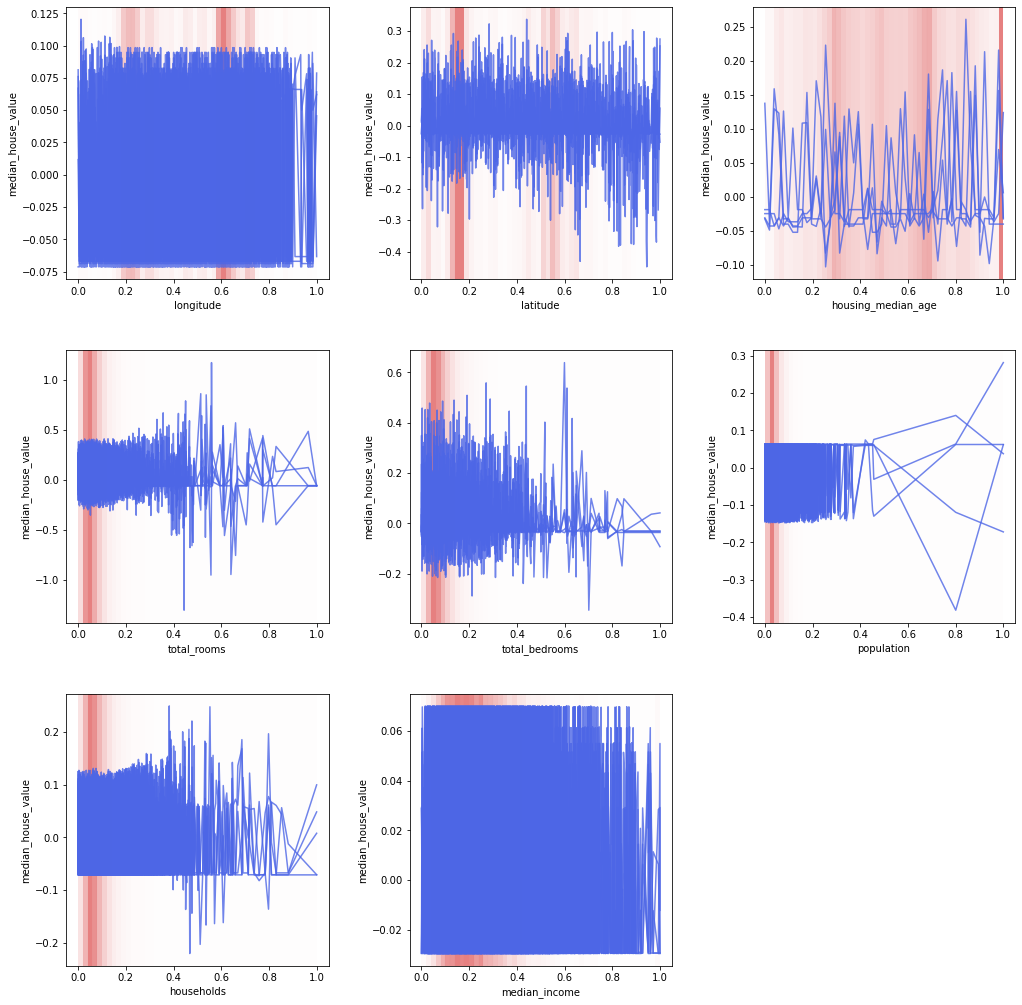

In [22]:
nam_plot(dataset, models)

In [ ]:
!conda install gxx_linux-64 gcc_linux-64 swig

Solving environment: failed with initial frozen solve. Retrying with flexible solve.

In [109]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_boston
from sklearn.metrics import r2_score
import torch 
import torch.nn as nn
import torch.nn.functional as F


# X, y = load_boston(return_X_y=True)
# X.shape
# y.shape
housing = sklearn.datasets.fetch_california_housing()
data = pd.DataFrame(data=housing.data, columns=housing.feature_names)
data['target'] = housing.target
data
X= data.iloc[:, :-1].values
y= data.iloc[:,-1].values
# data = pd.read_csv('data/housing.csv')
# data = data.drop(columns=['ocean_proximity'])
# data = data.dropna()
# y=data.iloc[:,-1].values

# # data =(data-data.mean())/data.std()
# # data = data.interpolate(method='linear', axis=0)
# X= data.iloc[:, :-1].values


scaler = MinMaxScaler()


X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2137)

X_train = torch.from_numpy(X_train.astype('float32'))
X_test = torch.from_numpy(X_test.astype('float32'))
y_train = torch.from_numpy(y_train.reshape(-1, 1).astype('float32'))
y_test = torch.from_numpy(y_test.reshape(-1, 1).astype('float32'))

dataset_train = torch.utils.data.TensorDataset(X_train, y_train)
dataset_train = torch.utils.data.DataLoader(dataset_train, batch_size=32, shuffle=True)


class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(8, 32)
        self.layer2 = nn.Linear(32, 16)
        self.layer3 = nn.Linear(16, 12)
        self.layer4 = nn.Linear(12, 1)
        self.dropout1 = nn.Dropout(0.1)
        self.dropout2 = nn.Dropout(0.1)
        self.dropout3 = nn.Dropout(0.1)

    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = self.dropout1(x)
        x = F.relu(self.layer2(x))
        x = self.dropout2(x)
        x = F.relu(self.layer3(x))
        x = self.dropout3(x)
        x = self.layer4(x)
        return x

model = NeuralNetwork()

loss_obj = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters())

for i in range(3):
    optimizer.zero_grad()
    for X, y in dataset_train:
        y_pred = model(X)
        loss = loss_obj(y_pred, y)
#         print(loss)
        loss.backward()
        optimizer.step()

y_pred = model(X_test)
r2_score(y_test.detach().numpy(), y_pred.detach().numpy())

0.27954246955438156

In [107]:
housing = sklearn.datasets.fetch_california_housing()
dataset = pd.DataFrame(data=housing.data, columns=housing.feature_names)
dataset['target'] = housing.target
dataset

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,target
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422
...,...,...,...,...,...,...,...,...,...
20635,1.5603,25.0,5.045455,1.133333,845.0,2.560606,39.48,-121.09,0.781
20636,2.5568,18.0,6.114035,1.315789,356.0,3.122807,39.49,-121.21,0.771
20637,1.7000,17.0,5.205543,1.120092,1007.0,2.325635,39.43,-121.22,0.923
20638,1.8672,18.0,5.329513,1.171920,741.0,2.123209,39.43,-121.32,0.847


In [105]:
sklearndata.data

array([[   8.3252    ,   41.        ,    6.98412698, ...,    2.55555556,
          37.88      , -122.23      ],
       [   8.3014    ,   21.        ,    6.23813708, ...,    2.10984183,
          37.86      , -122.22      ],
       [   7.2574    ,   52.        ,    8.28813559, ...,    2.80225989,
          37.85      , -122.24      ],
       ...,
       [   1.7       ,   17.        ,    5.20554273, ...,    2.3256351 ,
          39.43      , -121.22      ],
       [   1.8672    ,   18.        ,    5.32951289, ...,    2.12320917,
          39.43      , -121.32      ],
       [   2.3886    ,   16.        ,    5.25471698, ...,    2.61698113,
          39.37      , -121.24      ]])

In [102]:
data = pd.read_csv('data/housing.csv')
data

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY
...,...,...,...,...,...,...,...,...,...,...
20635,-121.09,39.48,25.0,1665.0,374.0,845.0,330.0,1.5603,78100.0,INLAND
20636,-121.21,39.49,18.0,697.0,150.0,356.0,114.0,2.5568,77100.0,INLAND
20637,-121.22,39.43,17.0,2254.0,485.0,1007.0,433.0,1.7000,92300.0,INLAND
20638,-121.32,39.43,18.0,1860.0,409.0,741.0,349.0,1.8672,84700.0,INLAND


In [52]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

data = pd.read_csv('data/GALLUP.csv')
data.head(3)

,WP16,wgt,country,income_2,WP1219,WP1220,year,weo_gdpc_con_ppp
0,4,1.800488,Israel,18042.77108,1.0,15.0,2016,32658.020
1,4,2.360024,Israel,12799.41274,1.0,15.0,2013,31369.909
2,8,1.463117,Israel,22448.93600,1.0,15.0,2015,32038.697


In [2]:
data["WP16"] = np.where(data["WP16"] < 6, 0, 1)

In [3]:
y=data.iloc[:,0].values

In [4]:
data = data.drop('country', axis=1)
data =(data-data.mean())/data.std()
data = data.interpolate(method='linear', axis=0)

In [5]:
data.head(3)

,WP16,wgt,income_2,WP1219,WP1220,year,weo_gdpc_con_ppp
0,-0.954120,1.184700,-0.007673,-1.065434,-1.488956,1.344815,0.642051
1,-0.954120,2.010882,-0.012368,-1.065434,-1.488956,0.075571,0.575457
2,1.048085,0.686555,-0.003729,-1.065434,-1.488956,0.921734,0.610033


In [6]:
x= data.iloc[:,1:].values
# y=data.iloc[:,0].values
x, y

(array([[ 1.1846996 , -0.00767343, -1.06543378, -1.48895611,  1.34481481,
          0.64205117],
        [ 2.0108822 , -0.01236773, -1.06543378, -1.48895611,  0.075571  ,
          0.57545723],
        [ 0.68655482, -0.00372865, -1.06543378, -1.48895611,  0.92173354,
          0.61003285],
        ...,
        [ 0.42526419, -0.02382686, -1.06543378,  3.28267659, -0.77059155,
         -0.9470326 ],
        [-0.52427233, -0.02125759, -1.06543378,  3.28267659, -0.77059155,
         -0.9470326 ],
        [-0.04950407,  0.00828902, -1.06543378,  3.28267659, -0.77059155,
         -0.9470326 ]]),
 array([0, 0, 1, ..., 0, 0, 1]))

In [7]:
from sklearn.preprocessing import LabelEncoder 
ly = LabelEncoder()
y = ly.fit_transform(y)

In [8]:
y

array([0, 0, 1, ..., 0, 0, 1])

In [9]:
data.columns

Index(['WP16', 'wgt', 'income_2', 'WP1219', 'WP1220', 'year',
       'weo_gdpc_con_ppp'],
      dtype='object')

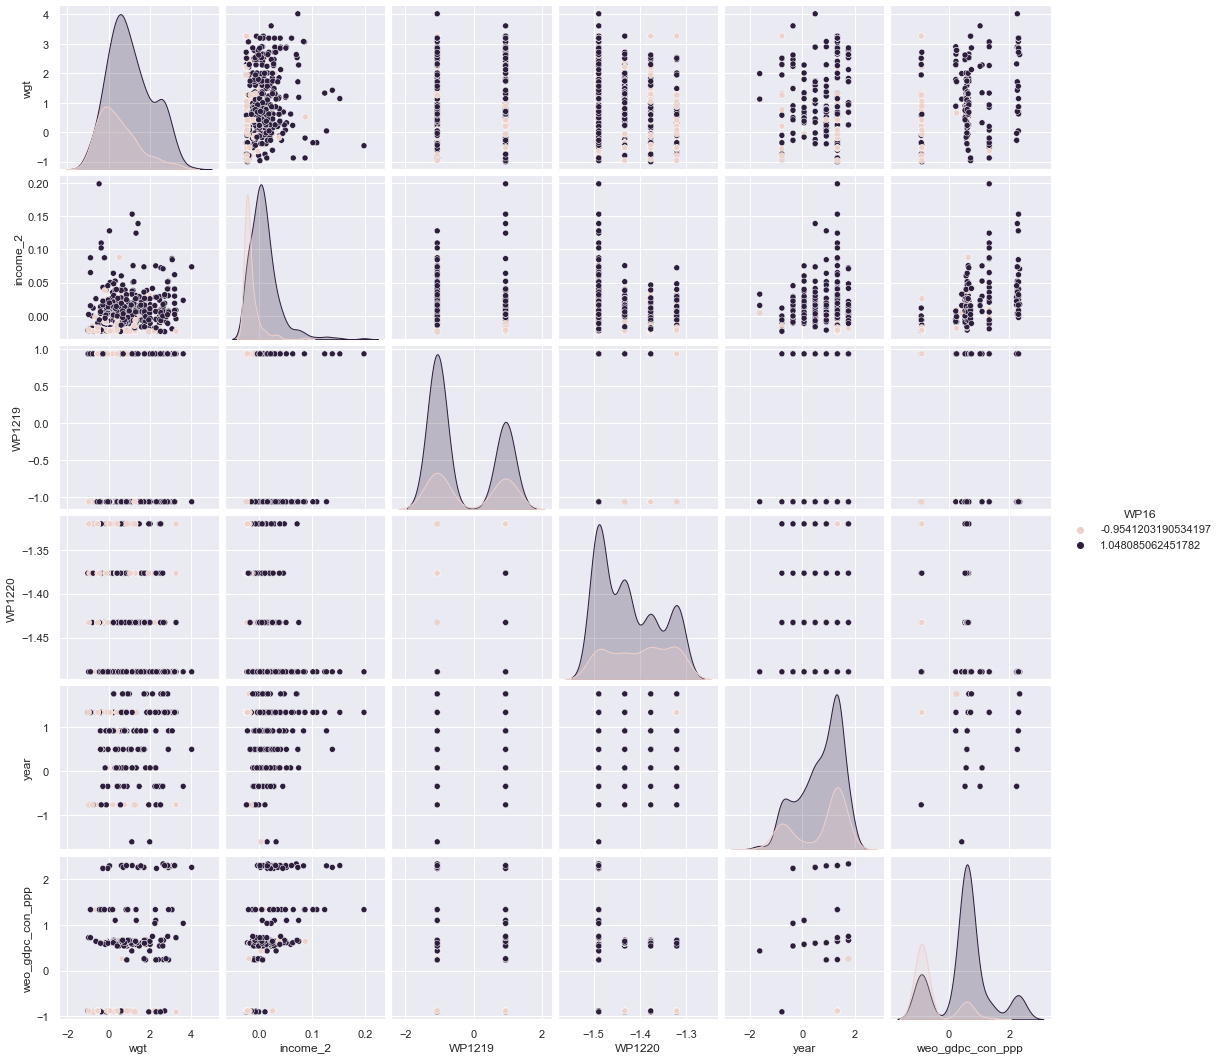

In [10]:
sns.set()
sns.pairplot(data[:500], hue="WP16", diag_kind="kde")

In [11]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2)

In [14]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
gnb.fit(x_train,y_train)

y_pred_test = gnb.predict(x_test)

from sklearn.metrics import accuracy_score
acc = accuracy_score(y_test,y_pred_test)

In [15]:
acc

0.5579575033002439

In [16]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier()
dt.fit(x_train,y_train)

y_pred2 = dt.predict(x_test)
acc2 = accuracy_score(y_test,y_pred2)
acc2

0.6261886471610445

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
clf = KNeighborsClassifier(n_neighbors=3,algorithm='ball_tree')

clf.fit(x_train,y_train)
y_pred3 = clf.predict(x_test)
acc3 =   accuracy_score(y_test,y_pred3)
acc3

In [ ]:
from sklearn.svm import SVC
SVC?

In [ ]:
from sklearn.svm import SVC
svc1 = SVC(C=50,kernel='rbf',gamma=1)     

svc1.fit(x_train,y_train)
y_pred4 = svc1.predict(x_test)

from sklearn.metrics import accuracy_score
acc4=    accuracy_score(y_test,y_pred4)
acc4

In [12]:
import numpy as np
from deeptables.models import deeptable, deepnets
from deeptables.datasets import dsutils
from sklearn.model_selection import train_test_split

# #loading data
# df = dsutils.load_bank()
# df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)

# y = df_train.pop('y')
# y_test = df_test.pop('y')

# #training
# config = deeptable.ModelConfig(nets=deepnets.DeepFM)
# dt = deeptable.DeepTable(config=config)
# model, history = dt.fit(df_train, y, epochs=10)

# #evaluation
# result = dt.evaluate(df_test,y_test, batch_size=512, verbose=0)
# print(result)

# #scoring
# preds = dt.predict(df_test)

In [36]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

data = pd.read_csv('data/housing.csv')
data.head(3)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY


In [37]:
data = data.drop(columns=['ocean_proximity'])

In [38]:
y=data.iloc[:,-1].values

In [39]:
y

array([452600., 358500., 352100., ...,  92300.,  84700.,  89400.])

In [40]:
# data = data.drop('country', axis=1)
data =(data-data.mean())/data.std()
data = data.interpolate(method='linear', axis=0)

In [41]:
data.head(3)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
0,-1.327803,1.052523,0.982119,-0.804800,-0.970301,-0.974405,-0.977009,2.344709,2.129580
1,-1.322812,1.043159,-0.607004,2.045841,1.348243,0.861418,1.669921,2.332181,1.314124
2,-1.332794,1.038478,1.856137,-0.535733,-0.825541,-0.820757,-0.843616,1.782656,1.258663


In [159]:
data = df

In [42]:
x= data.iloc[:,:-1].values
# y=data.iloc[:,0].values
x, y

(array([[-1.32780305,  1.05252278,  0.98211887, ..., -0.97440499,
         -0.97700919,  2.34470896],
        [-1.32281187,  1.04315928, -0.60700421, ...,  0.861418  ,
          1.66992057,  2.33218146],
        [-1.33279424,  1.03847753,  1.85613656, ..., -0.82075747,
         -0.84361648,  1.78265622],
        ...,
        [-0.82369324,  1.77819439, -0.92482882, ..., -0.36952825,
         -0.17403741, -1.14256563],
        [-0.87360511,  1.77819439, -0.84537267, ..., -0.60441469,
         -0.39374304, -1.05455737],
        [-0.83367562,  1.75010387, -1.00428498, ..., -0.03397619,
          0.07967028, -0.78011057]]),
 array([452600., 358500., 352100., ...,  92300.,  84700.,  89400.]))

In [30]:
from sklearn.preprocessing import LabelEncoder 
ly = LabelEncoder()
y = ly.fit_transform(y)

In [43]:
y

array([452600., 358500., 352100., ...,  92300.,  84700.,  89400.])

In [44]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2)

In [45]:
x_train.shape, y_train.shape

((16512, 8), (16512,))

In [50]:
#training
config = deeptable.ModelConfig(nets=deepnets.DeepFM, 
                              categorical_columns='auto', # or categorical_columns=['x1', 'x2', 'x3', ...]
#                                 metrics=['AUC', 'accuracy'], # can be `metrics=['RootMeanSquaredError']` for regression task
                                metrics=['RootMeanSquaredError'],
                                auto_categorize=True,
                                auto_discrete=True,
                                embeddings_output_dim=32,
                                embedding_dropout=0.5,)
dt = deeptable.DeepTable(config=config)
model, history = dt.fit(x_train, y_train, batch_size=2048, epochs=10)

#evaluation
result = dt.evaluate(x_test,y_test, batch_size=1024, verbose=0)
print(result)

#scoring
preds = dt.predict(x_test)

Column index of X has been converted: Index(['x_0', 'x_1', 'x_2', 'x_3', 'x_4', 'x_5', 'x_6', 'x_7'], dtype='object')


Target column type is float, so inferred as a [regression] task.
Preparing features taken 0.020405054092407227s
Imputation taken 0.023392677307128906s
Categorical encoding taken 0.00812530517578125s
Discretization taken 0.0769500732421875s
Injected a callback [EarlyStopping]. monitor:val_rootmeansquarederror, patience:1, mode:min
>>>>>>>>>>>>>>>>>>>>>> Model Desc <<<<<<<<<<<<<<<<<<<<<<< 
---------------------------------------------------------
inputs:
---------------------------------------------------------
['all_categorical_vars: (9)', 'input_continuous_all: (8)']
---------------------------------------------------------
embeddings:
---------------------------------------------------------
input_dims: [54, 7, 7, 11, 9, 10, 8, 12, 5]
output_dims: [32, 32, 32, 32, 32, 32, 32, 32, 32]
dropout: 0.5
---------------------------------------------------------
dense: dropout: 0
batch_normalization: False
---------------------------------------------------------
concat_embed_dense: shape: (No

Column index of X has been converted: Index(['x_0', 'x_1', 'x_2', 'x_3', 'x_4', 'x_5', 'x_6', 'x_7'], dtype='object')


Model has been saved to:dt_output/dt_20210407 154125_dnn_nets_linear_fm_nets/dnn_nets+linear+fm_nets.h5


Column index of X has been converted: Index(['x_0', 'x_1', 'x_2', 'x_3', 'x_4', 'x_5', 'x_6', 'x_7'], dtype='object')


{'loss': 56329687040.0, 'root_mean_squared_error': 237338.765625}


---
---
---

In [78]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

data = pd.read_csv('data/housing.csv')
data.head(3)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY


In [ ]:
data = pd.read_csv('data/housing.csv')
data = data.drop(columns=['ocean_proximity'])
y=data.iloc[:,-1].values
data =(data-data.mean())/data.std()
data = data.interpolate(method='linear', axis=0)
x= data.iloc[:, :-1].values

In [79]:
data = data.drop(columns=['ocean_proximity'])

In [80]:
y=data.iloc[:,-1].values
y

array([452600., 358500., 352100., ...,  92300.,  84700.,  89400.])

In [81]:
# data = data.drop('country', axis=1)
data =(data-data.mean())/data.std()
data = data.interpolate(method='linear', axis=0)

In [82]:
data.head(3)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
0,-1.327803,1.052523,0.982119,-0.804800,-0.970301,-0.974405,-0.977009,2.344709,2.129580
1,-1.322812,1.043159,-0.607004,2.045841,1.348243,0.861418,1.669921,2.332181,1.314124
2,-1.332794,1.038478,1.856137,-0.535733,-0.825541,-0.820757,-0.843616,1.782656,1.258663


In [83]:
x= data.iloc[:, :-1].values
# y=data.iloc[:,0].values
x, y

(array([[-1.32780305,  1.05252278,  0.98211887, ..., -0.97440499,
         -0.97700919,  2.34470896],
        [-1.32281187,  1.04315928, -0.60700421, ...,  0.861418  ,
          1.66992057,  2.33218146],
        [-1.33279424,  1.03847753,  1.85613656, ..., -0.82075747,
         -0.84361648,  1.78265622],
        ...,
        [-0.82369324,  1.77819439, -0.92482882, ..., -0.36952825,
         -0.17403741, -1.14256563],
        [-0.87360511,  1.77819439, -0.84537267, ..., -0.60441469,
         -0.39374304, -1.05455737],
        [-0.83367562,  1.75010387, -1.00428498, ..., -0.03397619,
          0.07967028, -0.78011057]]),
 array([452600., 358500., 352100., ...,  92300.,  84700.,  89400.]))

In [59]:
data.columns

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'median_house_value'],
      dtype='object')

In [84]:
# sns.set()
# sns.pairplot(data[:500], hue="median_house_value", diag_kind="kde")

In [85]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2)

In [86]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
gnb.fit(x_train,y_train)

y_pred_test = gnb.predict(x_test)

from sklearn.metrics import r2_score
r2 = r2_score(y_test, y_pred_test)
r2

0.3215588133289874

In [73]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier()
dt.fit(x_train,y_train)

from sklearn.metrics import r2_score
r2 = r2_score(y_test, y_pred_test)
r2

KeyboardInterrupt: 

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
clf = KNeighborsClassifier(n_neighbors=3,algorithm='ball_tree')

clf.fit(x_train,y_train)
y_pred3 = clf.predict(x_test)
acc3 =   accuracy_score(y_test,y_pred3)
acc3

In [ ]:
from sklearn.svm import SVC
SVC?

In [ ]:
from sklearn.svm import SVC
svc1 = SVC(C=50,kernel='rbf',gamma=1)     

svc1.fit(x_train,y_train)
y_pred4 = svc1.predict(x_test)

from sklearn.metrics import accuracy_score
acc4=    accuracy_score(y_test,y_pred4)
acc4

In [74]:
import numpy as np
from deeptables.models import deeptable, deepnets
from deeptables.datasets import dsutils
from sklearn.model_selection import train_test_split

# #loading data
# df = dsutils.load_bank()
# df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)

# y = df_train.pop('y')
# y_test = df_test.pop('y')

# #training
# config = deeptable.ModelConfig(nets=deepnets.DeepFM)
# dt = deeptable.DeepTable(config=config)
# model, history = dt.fit(df_train, y, epochs=10)

# #evaluation
# result = dt.evaluate(df_test,y_test, batch_size=512, verbose=0)
# print(result)

# #scoring
# preds = dt.predict(df_test)

In [87]:
# x= data.iloc[:,:-1].values
# y=data.iloc[:,0].values
x, y

(array([[-1.32780305,  1.05252278,  0.98211887, ..., -0.97440499,
         -0.97700919,  2.34470896],
        [-1.32281187,  1.04315928, -0.60700421, ...,  0.861418  ,
          1.66992057,  2.33218146],
        [-1.33279424,  1.03847753,  1.85613656, ..., -0.82075747,
         -0.84361648,  1.78265622],
        ...,
        [-0.82369324,  1.77819439, -0.92482882, ..., -0.36952825,
         -0.17403741, -1.14256563],
        [-0.87360511,  1.77819439, -0.84537267, ..., -0.60441469,
         -0.39374304, -1.05455737],
        [-0.83367562,  1.75010387, -1.00428498, ..., -0.03397619,
          0.07967028, -0.78011057]]),
 array([452600., 358500., 352100., ...,  92300.,  84700.,  89400.]))

In [88]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2)

In [89]:
x_train.shape, y_train.shape

((16512, 8), (16512,))

In [90]:
#training
config = deeptable.ModelConfig(nets=deepnets.DeepFM, 
                              categorical_columns='auto', # or categorical_columns=['x1', 'x2', 'x3', ...]
#                                 metrics=['AUC', 'accuracy'], # can be `metrics=['RootMeanSquaredError']` for regression task
                                metrics=['RootMeanSquaredError'],
                                auto_categorize=True,
                                auto_discrete=True,
                                embeddings_output_dim=32,
                                embedding_dropout=0.5,)
dt = deeptable.DeepTable(config=config)
model, history = dt.fit(x_train, y_train, batch_size=2048, epochs=10)

#evaluation
result = dt.evaluate(x_test,y_test, batch_size=1024, verbose=0)
print(result)

#scoring
preds = dt.predict(x_test)

Column index of X has been converted: Index(['x_0', 'x_1', 'x_2', 'x_3', 'x_4', 'x_5', 'x_6', 'x_7'], dtype='object')


Target column type is float, so inferred as a [regression] task.
Preparing features taken 0.022232770919799805s
Imputation taken 0.02314591407775879s
Categorical encoding taken 0.0071599483489990234s
Discretization taken 0.07288074493408203s
Injected a callback [EarlyStopping]. monitor:val_rootmeansquarederror, patience:1, mode:min
>>>>>>>>>>>>>>>>>>>>>> Model Desc <<<<<<<<<<<<<<<<<<<<<<< 
---------------------------------------------------------
inputs:
---------------------------------------------------------
['all_categorical_vars: (9)', 'input_continuous_all: (8)']
---------------------------------------------------------
embeddings:
---------------------------------------------------------
input_dims: [54, 7, 7, 11, 9, 10, 8, 12, 5]
output_dims: [32, 32, 32, 32, 32, 32, 32, 32, 32]
dropout: 0.5
---------------------------------------------------------
dense: dropout: 0
batch_normalization: False
---------------------------------------------------------
concat_embed_dense: shape: (

Column index of X has been converted: Index(['x_0', 'x_1', 'x_2', 'x_3', 'x_4', 'x_5', 'x_6', 'x_7'], dtype='object')


Model has been saved to:dt_output/dt_20210407 154655_dnn_nets_linear_fm_nets/dnn_nets+linear+fm_nets.h5


Column index of X has been converted: Index(['x_0', 'x_1', 'x_2', 'x_3', 'x_4', 'x_5', 'x_6', 'x_7'], dtype='object')


{'loss': 54462861312.0, 'root_mean_squared_error': 233372.796875}


# DATA PROCESSING

In [147]:
import pandas as pd
df = pd.read_csv('data/GALLUP.csv')
df.head(10)

,WP16,wgt,country,income_2,WP1219,WP1220,year,weo_gdpc_con_ppp
0,4,1.800488,Israel,18042.77108,1.0,15.0,2016,32658.020
1,4,2.360024,Israel,12799.41274,1.0,15.0,2013,31369.909
2,8,1.463117,Israel,22448.93600,1.0,15.0,2015,32038.697
3,5,1.246618,Israel,16853.73974,1.0,15.0,2014,31844.204
4,8,1.800488,Israel,22206.48749,1.0,15.0,2016,32658.020
5,10,1.463117,Israel,23851.99449,1.0,15.0,2015,32038.697
6,9,1.246618,Israel,50561.21923,1.0,15.0,2014,31844.204
7,9,1.350366,Israel,33309.73123,1.0,15.0,2016,32658.020
8,10,1.800488,Israel,83274.32807,1.0,15.0,2016,32658.020
9,8,1.463117,Israel,28061.16999,1.0,15.0,2015,32038.697


In [148]:
df.isna().sum()

WP16                    0
wgt                     0
country                 0
income_2                0
WP1219                  1
WP1220                185
year                    0
weo_gdpc_con_ppp    24122
dtype: int64

In [149]:
df = df.interpolate(method ='linear', limit_direction ='forward')

In [150]:
# df = df.drop(columns=['year', 'country'])

In [151]:
df.head()

,WP16,wgt,country,income_2,WP1219,WP1220,year,weo_gdpc_con_ppp
0,4,1.800488,Israel,18042.77108,1.0,15.0,2016,32658.020
1,4,2.360024,Israel,12799.41274,1.0,15.0,2013,31369.909
2,8,1.463117,Israel,22448.93600,1.0,15.0,2015,32038.697
3,5,1.246618,Israel,16853.73974,1.0,15.0,2014,31844.204
4,8,1.800488,Israel,22206.48749,1.0,15.0,2016,32658.020


In [152]:
df = df.drop_duplicates(keep=False)

In [123]:
def encode_and_bind(original_dataframe, feature_to_encode):
    dummies = pd.get_dummies(original_dataframe[[feature_to_encode]])
    res = pd.concat([original_dataframe, dummies], axis=1)
    res = res.drop([feature_to_encode], axis=1)
    return(res) 

In [124]:
df2 = encode_and_bind(df, 'year')
df2 = encode_and_bind(df2, 'country')
df2.head()

,WP16,wgt,income_2,WP1219,WP1220,weo_gdpc_con_ppp,country_Afghanistan,country_Albania,country_Algeria,country_Angola,...,country_Ukraine,country_United Arab Emirates,country_United Kingdom,country_United States,country_Uruguay,"country_Venezuela, RB",country_Vietnam,"country_Yemen, Rep.",country_Zambia,country_Zimbabwe
0,4,1.800488,18042.77108,1.0,15.0,32658.020,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,4,2.360024,12799.41274,1.0,15.0,31369.909,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,8,1.463117,22448.93600,1.0,15.0,32038.697,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,5,1.246618,16853.73974,1.0,15.0,31844.204,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,8,1.800488,22206.48749,1.0,15.0,32658.020,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [125]:
df = df2

In [153]:
columns = ['wgt', 'income_2', 'WP1219', 'WP1220', 'weo_gdpc_con_ppp']
df[columns] = df[columns].apply(lambda x: (x - x.min()) / (x.max() - x.min()))

In [154]:
df.head()

,WP16,wgt,country,income_2,WP1219,WP1220,year,weo_gdpc_con_ppp
0,4,0.229189,Israel,0.000020,0.0,0.022727,2016,0.220878
1,4,0.303079,Israel,0.000014,0.0,0.022727,2013,0.212002
2,8,0.184638,Israel,0.000025,0.0,0.022727,2015,0.216610
3,5,0.156048,Israel,0.000019,0.0,0.022727,2014,0.215270
4,8,0.229189,Israel,0.000025,0.0,0.022727,2016,0.220878


In [155]:
df["WP16"] = np.where(df["WP16"]<6, 0, 1)

In [156]:
df.head()

,WP16,wgt,country,income_2,WP1219,WP1220,year,weo_gdpc_con_ppp
0,0,0.229189,Israel,0.000020,0.0,0.022727,2016,0.220878
1,0,0.303079,Israel,0.000014,0.0,0.022727,2013,0.212002
2,1,0.184638,Israel,0.000025,0.0,0.022727,2015,0.216610
3,0,0.156048,Israel,0.000019,0.0,0.022727,2014,0.215270
4,1,0.229189,Israel,0.000025,0.0,0.022727,2016,0.220878


In [133]:
list(df.columns)[2:]

['income_2',
 'WP1219',
 'WP1220',
 'weo_gdpc_con_ppp',
 'country_Afghanistan',
 'country_Albania',
 'country_Algeria',
 'country_Angola',
 'country_Argentina',
 'country_Armenia',
 'country_Australia',
 'country_Austria',
 'country_Azerbaijan',
 'country_Bahrain',
 'country_Bangladesh',
 'country_Belarus',
 'country_Belgium',
 'country_Belize',
 'country_Benin',
 'country_Bhutan',
 'country_Bolivia',
 'country_Bosnia and Herzegovina',
 'country_Botswana',
 'country_Brazil',
 'country_Bulgaria',
 'country_Burkina Faso',
 'country_Burundi',
 'country_Cambodia',
 'country_Cameroon',
 'country_Canada',
 'country_Central African Republic',
 'country_Chad',
 'country_Chile',
 'country_China',
 'country_Colombia',
 'country_Comoros',
 'country_Congo, Dem. Rep.',
 'country_Congo, Rep.',
 'country_Costa Rica',
 "country_Cote d'Ivoire",
 'country_Croatia',
 'country_Cyprus',
 'country_Czech Republic',
 'country_Denmark',
 'country_Dominican Republic',
 'country_Ecuador',
 'country_Egypt, Arab R

In [157]:
from sklearn.preprocessing import LabelEncoder 
ly = LabelEncoder()
# y = ly.fit_transform(y)

In [158]:
columns = ['year', 'country']
df[columns] = df[columns].apply(lambda x: ly.fit_transform(x))

In [159]:
df.head()

,WP16,wgt,country,income_2,WP1219,WP1220,year,weo_gdpc_con_ppp
0,0,0.229189,65,0.000020,0.0,0.022727,7,0.220878
1,0,0.303079,65,0.000014,0.0,0.022727,4,0.212002
2,1,0.184638,65,0.000025,0.0,0.022727,6,0.216610
3,0,0.156048,65,0.000019,0.0,0.022727,5,0.215270
4,1,0.229189,65,0.000025,0.0,0.022727,7,0.220878


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

data = pd.read_csv('data/GALLUP.csv')
data.head(3)

y=data.iloc[:,0].values

data = data.drop('country', axis=1)
data =(data-data.mean())/data.std()
data = data.interpolate(method='linear', axis=0)

data.head(3)

x= data.iloc[:,1:].values
# y=data.iloc[:,0].values
x, y

from sklearn.preprocessing import LabelEncoder 
ly = LabelEncoder()
y = ly.fit_transform(y)

y

data.columns

sns.set()
sns.pairplot(data[:1000], hue="WP16", diag_kind="kde")

from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2)

from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
gnb.fit(x_train,y_train)

y_pred_test = gnb.predict(x_test)

from sklearn.metrics import accuracy_score
acc = accuracy_score(y_test,y_pred_test)

acc

from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier()
dt.fit(x_train,y_train)

y_pred2 = dt.predict(x_test)
acc2 = accuracy_score(y_test,y_pred2)
acc2

from sklearn.neighbors import KNeighborsClassifier
clf = KNeighborsClassifier(n_neighbors=3,algorithm='ball_tree')

clf.fit(x_train,y_train)
y_pred3 = clf.predict(x_test)
acc3 =   accuracy_score(y_test,y_pred3)
acc3

from sklearn.svm import SVC
svc1 = SVC(C=50,kernel='rbf',gamma=1)     

svc1.fit(x_train,y_train)
y_pred4 = svc1.predict(x_test)

from sklearn.metrics import accuracy_score
acc4=    accuracy_score(y_test,y_pred4)
acc4

import numpy as np
from deeptables.models import deeptable, deepnets
from deeptables.datasets import dsutils
from sklearn.model_selection import train_test_split

# #loading data
# df = dsutils.load_bank()
# df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)

# y = df_train.pop('y')
# y_test = df_test.pop('y')

# #training
# config = deeptable.ModelConfig(nets=deepnets.DeepFM)
# dt = deeptable.DeepTable(config=config)
# model, history = dt.fit(df_train, y, epochs=10)

# #evaluation
# result = dt.evaluate(df_test,y_test, batch_size=512, verbose=0)
# print(result)

# #scoring
# preds = dt.predict(df_test)

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

data = pd.read_csv('data/GALLUP.csv')
data.head(3)

y=data.iloc[:,0].values

# data = data.drop('country', axis=1)
# data =(data-data.mean())/data.std()
data = data.interpolate(method='linear', axis=0)

data.head(3)

data = df

x= data.iloc[:,1:].values
y=data.iloc[:,0].values
x, y

from sklearn.preprocessing import LabelEncoder 
ly = LabelEncoder()
y = ly.fit_transform(y)

y

from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2)

x_train.shape, y_train.shape

#training
config = deeptable.ModelConfig(nets=deepnets.DeepFM, 
                              categorical_columns='auto', # or categorical_columns=['x1', 'x2', 'x3', ...]
                                metrics=['AUC', 'accuracy'], # can be `metrics=['RootMeanSquaredError']` for regression task
                                auto_categorize=True,
                                auto_discrete=False,
                                embeddings_output_dim=20,
                                embedding_dropout=0.3,)
dt = deeptable.DeepTable(config=config)
model, history = dt.fit(x_train, y_train, batch_size=2048, epochs=3)

#evaluation
result = dt.evaluate(x_test,y_test, batch_size=1024, verbose=0)
print(result)

#scoring
preds = dt.predict(x_test)

# DATA PROCESSING

import pandas as pd
df = pd.read_csv('data/GALLUP.csv')
df.head(10)

df.isna().sum()

df = df.interpolate(method ='linear', limit_direction ='forward')

# df = df.drop(columns=['year', 'country'])

df.head()

df = df.drop_duplicates(keep=False)

def encode_and_bind(original_dataframe, feature_to_encode):
    dummies = pd.get_dummies(original_dataframe[[feature_to_encode]])
    res = pd.concat([original_dataframe, dummies], axis=1)
    res = res.drop([feature_to_encode], axis=1)
    return(res) 

df2 = encode_and_bind(df, 'year')
df2 = encode_and_bind(df2, 'country')
df2.head()

df = df2

columns = ['wgt', 'income_2', 'WP1219', 'WP1220', 'weo_gdpc_con_ppp']
df[columns] = df[columns].apply(lambda x: (x - x.min()) / (x.max() - x.min()))

df.head()

df["WP16"] = np.where(df["WP16"]<6, 0, 1)

df.head()

list(df.columns)[2:]

from sklearn.preprocessing import LabelEncoder 
ly = LabelEncoder()
# y = ly.fit_transform(y)

columns = ['year', 'country']
df[columns] = df[columns].apply(lambda x: ly.fit_transform(x))

df.head()



In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import seaborn as sns
import pandas as pd
import imageio

import time

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix

from tqdm.notebook import tqdm


from sklearn import metrics
from sklearn import preprocessing
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report



from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import ExtraTreesClassifier

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, WeightedRandomSampler

%matplotlib inline

In [2]:
torch.manual_seed(0); 

In [3]:
sns.set_style(style='whitegrid')
plt.rcParams["patch.force_edgecolor"] = True

In [4]:
from nam.config import defaults
from nam.data import NAMDataset
from nam.models import NAM, FeatureNN, DNN, get_num_units

## Config

In [5]:
config = defaults()
print(config)

Config(activation='exu', batch_size=1024, cross_val=False, data_split=1, debug=False, decay_rate=0.995, device='cpu', dropout=0.5, feature_dropout=0.0, fold_num=1, hidden_sizes=[64, 32], l2_regularization=0.0, lr=0.01, n_folds=5, n_models=1, num_basis_functions=1000, num_splits=3, num_units=64, num_workers=16, optimizer='adam', output_dir='output', output_regularization=0.0, patience=10, regression=False, seed=1377, shuffle=True, training_epochs=10, units_multiplier=2, use_dnn=False)


In [6]:
config.batch_size = 64
config.training_epochs = 200
config.hidden_sizes = [200, 100]
config.dropout = 0.0

## data

In [7]:
## QUAD
x = torch.unsqueeze(torch.linspace(-10, 10, 1000), dim=1)
y = x.pow(4) + x.pow(3) * x.pow(2) + 0.25 * torch.rand(x.size())             

In [8]:
# Sin
x = torch.unsqueeze(torch.linspace(-10, 10, 1000), dim=1)
y = torch.sin(x) + 0.25 * torch.rand(x.size())    

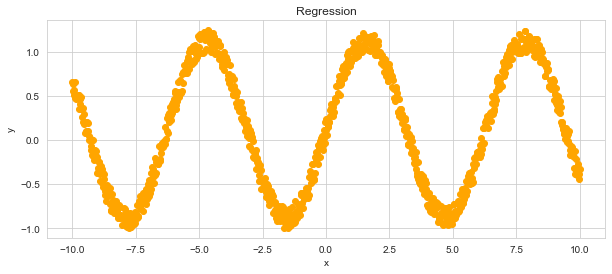

In [9]:
plt.figure(figsize=(10,4))
plt.scatter(x.data.numpy(), y.data.numpy(), color = "orange")
plt.title('Regression')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [10]:
dataset = torch.utils.data.TensorDataset(x, y)

dataloader = torch.utils.data.DataLoader(
    dataset=dataset, 
    batch_size=config.batch_size, 
    shuffle=True, num_workers=2, drop_last=True,
)

In [11]:
input_dim = dataset[0][0].shape[-1]; input_dim

1

In [12]:
get_num_units(config, dataloader)

[128]

In [13]:
model = FeatureNN(
  config=config,
  name=f'FeatureNN_{0}',
  input_shape=input_dim,
  num_units=get_num_units(config, dataloader)[0],
)
model

/Users/amrmkayid/anaconda3/envs/nam/lib/python3.7/site-packages/torch/nn/init.py:162: UserWarning: mean is more than 2 std from [a, b] in nn.init.trunc_normal_. The distribution of values may be incorrect.
  return _no_grad_trunc_normal_(tensor, mean, std, a, b)


FeatureNN(
  (model): ModuleList(
    (0): ExU(in_features=1, out_features=128)
    (1): LinReLU(in_features=128, out_features=200)
    (2): LinReLU(in_features=200, out_features=100)
    (3): Linear(in_features=100, out_features=1, bias=True)
  )
)

In [14]:
dict(model.named_parameters()).keys()

dict_keys(['model.0.weights', 'model.0.bias', 'model.1.weights', 'model.1.bias', 'model.2.weights', 'model.2.bias', 'model.3.weight', 'model.3.bias'])

In [15]:
model = DNN(config=config,)
model

DNN(
  (dropout): Dropout(p=0.0, inplace=False)
  (model): Sequential(
    (0): Linear(in_features=1, out_features=200, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.0, inplace=False)
    (3): Linear(in_features=200, out_features=100, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.0, inplace=False)
    (6): Linear(in_features=100, out_features=1, bias=True)
  )
)

In [14]:
dict(model.named_parameters()).keys()

dict_keys(['model.0.weights', 'model.0.bias', 'model.1.weights', 'model.1.bias', 'model.2.weights', 'model.2.bias', 'model.3.weight', 'model.3.bias'])

In [25]:
# model = torch.nn.Sequential(
#         torch.nn.Linear(1, 200),
#         torch.nn.LeakyReLU(),
#         torch.nn.Linear(200, 100),
#         torch.nn.LeakyReLU(),
#         torch.nn.Linear(100, 1),
#     )
# model

In [26]:
# dict(model.named_parameters()).keys()

In [15]:
optimizer = torch.optim.Adam(model.parameters(), lr=config.lr)
criterion = torch.nn.MSELoss() 

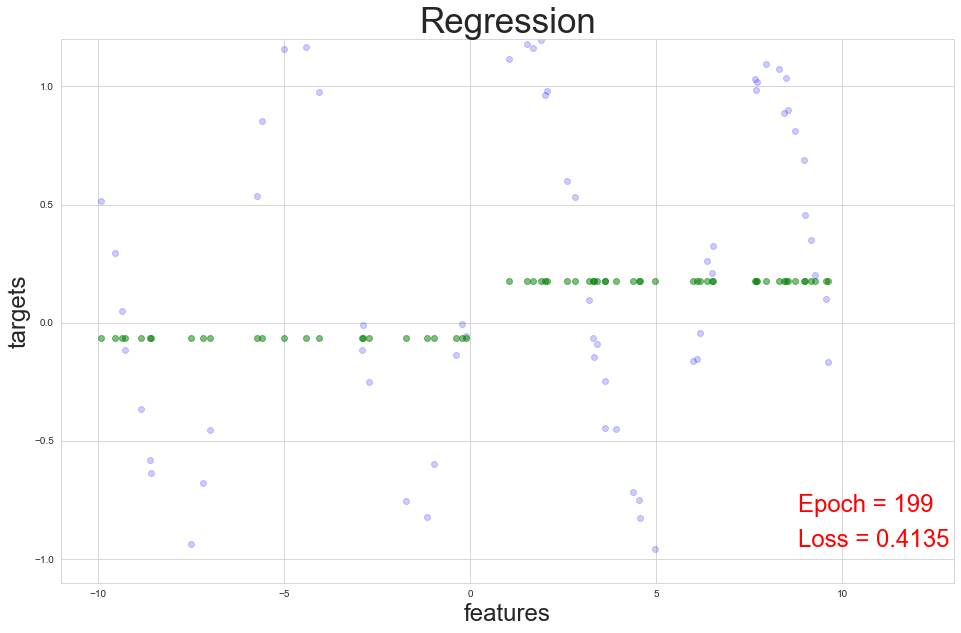

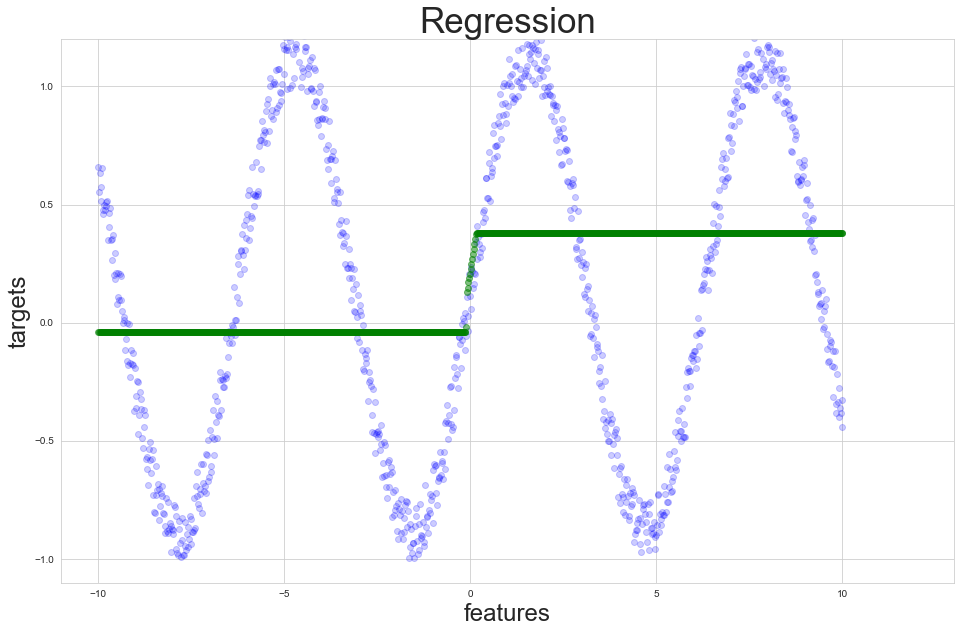

In [16]:
images = []
fig, ax = plt.subplots(figsize=(16, 10))

# start training
for epoch in range(config.training_epochs):
    for step, (features, targets) in enumerate(dataloader):

        prediction = model(features)

        loss = criterion(prediction, targets)  

        optimizer.zero_grad() 
        loss.backward()       
        optimizer.step()      

        if step == 1:
            plt.cla()
            ax.set_title('Regression', fontsize=35)
            ax.set_xlabel('features', fontsize=24)
            ax.set_ylabel('targets', fontsize=24)
            ax.set_xlim(-11.0, 13.0)
            ax.set_ylim(-1.1, 1.2)
            ax.scatter(features.data.numpy(), targets.data.numpy(), color = "blue", alpha=0.2)
            ax.scatter(features.data.numpy(), prediction.data.numpy(), color='green', alpha=0.5)
            ax.text(8.8, -0.8, 'Epoch = %d' % epoch,
                    fontdict={'size': 24, 'color':  'red'})
            ax.text(8.8, -0.95, 'Loss = %.4f' % loss.data.numpy(),
                    fontdict={'size': 24, 'color':  'red'})

            # Used to return the plot as an image array 
            # (https://ndres.me/post/matplotlib-animated-gifs-easily/)
            fig.canvas.draw()       # draw the canvas, cache the renderer
            image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
            image  = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))

            images.append(image)

    


# save images as a gif    
imageio.mimsave('./batch.gif', images, fps=12)


fig, ax = plt.subplots(figsize=(16,10))
plt.cla()
ax.set_title(f'Regression', fontsize=35)
ax.set_xlabel('features', fontsize=24)
ax.set_ylabel('targets', fontsize=24)
ax.set_xlim(-11.0, 13.0)
ax.set_ylim(-1.1, 1.2)
ax.scatter(x.data.numpy(), y.data.numpy(), color = "blue", alpha=0.2)
prediction = model(x)     # input x and predict based on x
ax.scatter(x.data.numpy(), prediction.data.numpy(), color='green', alpha=0.5)
plt.savefig('batches.png')
plt.show()

---
---
---

In [58]:
model = FeatureNN(
  config=config,
  name=f'FeatureNN_{0}',
  input_shape=input_dim,
  num_units=64,
)
model

/Users/amrmkayid/anaconda3/envs/nam/lib/python3.7/site-packages/torch/nn/init.py:162: UserWarning: mean is more than 2 std from [a, b] in nn.init.trunc_normal_. The distribution of values may be incorrect.
  return _no_grad_trunc_normal_(tensor, mean, std, a, b)


FeatureNN(
  (model): Sequential(
    (0): ExU(in_features=1, out_features=64)
    (1): LinReLU(in_features=64, out_features=64)
    (2): LinReLU(in_features=64, out_features=32)
    (3): Linear(in_features=32, out_features=1, bias=True)
  )
)

In [1]:
import time

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix

from tqdm.notebook import tqdm


from sklearn import metrics
from sklearn import preprocessing
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report



from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import ExtraTreesClassifier

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, WeightedRandomSampler

In [5]:
housing = pd.read_csv('data/housing.csv')
housing.head(3)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY


In [6]:
housing.isnull().any()

longitude             False
latitude              False
housing_median_age    False
total_rooms           False
total_bedrooms         True
population            False
households            False
median_income         False
median_house_value    False
ocean_proximity       False
dtype: bool

In [7]:
# with sns.plotting_context("paper") :
#     g = sns.pairplot(housing)
# g.set(xticklabels=[])

# plt.show()
# plt.clf()

In [8]:
from nam.config import defaults
from nam.data import NAMDataset
from nam.models import NAM, FeatureNN, DNN, get_num_units

## Config

In [9]:
config = defaults()
config

namespace(device='cpu',
          output_dir='output',
          training_epochs=10,
          lr=0.01,
          batch_size=1024,
          hidden_sizes=[64, 32],
          activation='exu',
          optimizer='adam',
          dropout=0.5,
          feature_dropout=0.0,
          decay_rate=0.995,
          l2_regularization=0.0,
          output_regularization=0.0,
          num_basis_functions=1000,
          units_multiplier=2,
          num_units=64,
          data_split=1,
          seed=1377,
          cross_val=False,
          n_models=1,
          num_splits=3,
          fold_num=1,
          shuffle=True,
          regression=False,
          debug=False,
          use_dnn=False,
          patience=10,
          n_folds=5,
          num_workers=16)

In [10]:
data = housing

In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [12]:
data.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


In [14]:
data.median_house_value.value_counts()

500001.0    965
137500.0    122
162500.0    117
112500.0    103
187500.0     93
           ... 
243700.0      1
454800.0      1
290200.0      1
486800.0      1
289700.0      1
Name: median_house_value, Length: 3842, dtype: int64

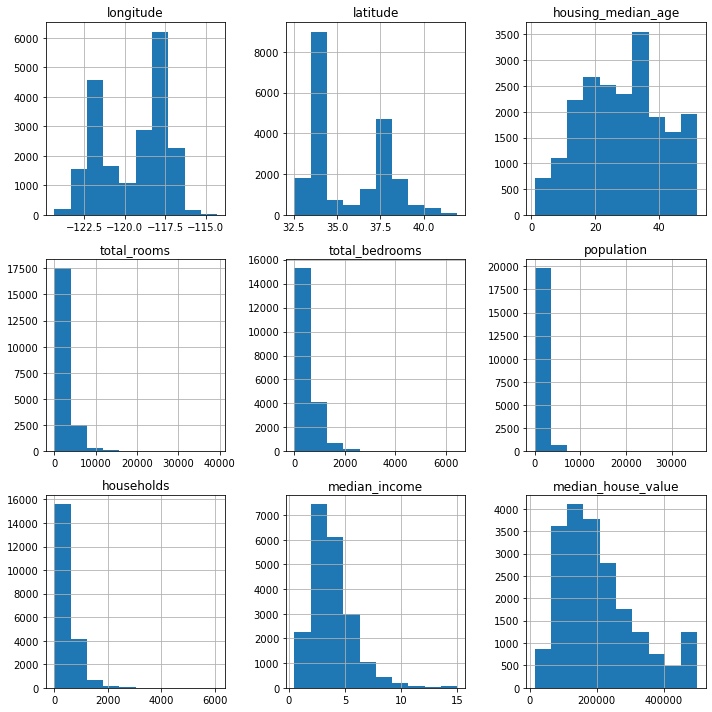

In [15]:
data.hist(figsize=(10,10))
plt.tight_layout()

### Correlations

<AxesSubplot:>

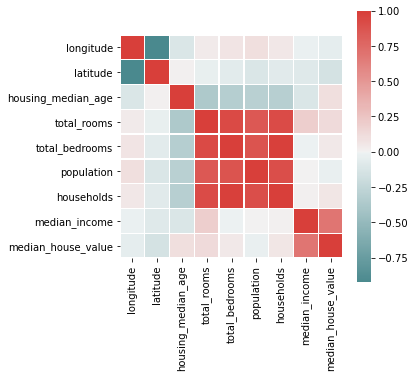

In [16]:
corr = data.corr()
f, ax = plt.subplots(figsize=(5, 5))
cmap = sns.diverging_palette(2000, 13, as_cmap=True)
sns.heatmap(corr, cmap=cmap, center=0,square=True, linewidths=.5)

### Outliers

<AxesSubplot:>

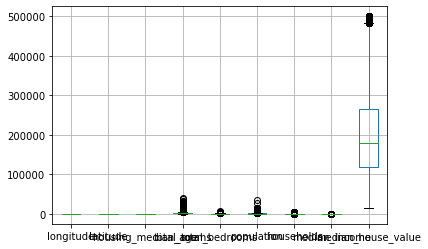

In [17]:
data.boxplot()

<AxesSubplot:>

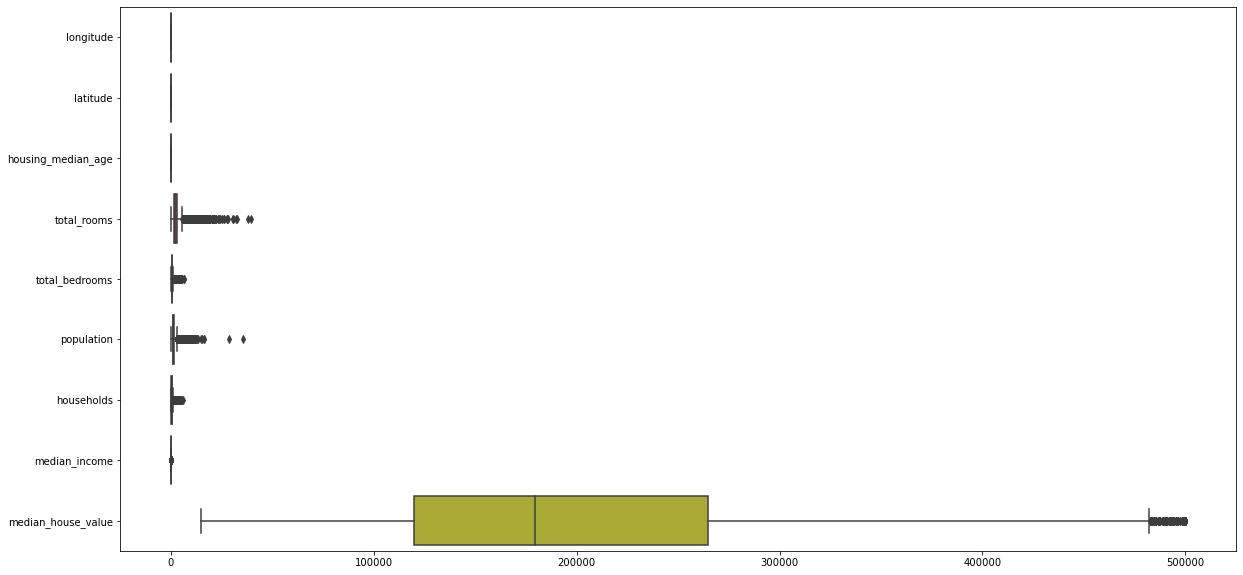

In [18]:
fig = plt.figure(figsize = (20,10))
ax = fig.gca()
sns.boxplot(data= data, orient="h",  ax = ax)

## Remove NaNs

In [19]:
data = data.interpolate(method='linear', axis=0)

In [20]:
dataset = NAMDataset(
    config=config,
    csv_file=data, #'data/GALLUP.csv',
    features_columns = ['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',],
    targets_column = ['median_house_value'],
#     weights_column = ["wgt"],   
#     one_hot=True,
)
dataset

NAMDatasetSample(features=tensor([-121.9600,   37.9600,   28.0000, 1838.0000,  273.0000,  899.0000,
         270.0000,    5.2145]), targets=tensor([203900]))

In [83]:
dataset = NAMDataset(
    config=config,
    csv_file=data, #'data/GALLUP.csv',
    features_columns = ["income_2", "WP1219", "WP1220", "weo_gdpc_con_ppp"],
    targets_column = ["WP16"],
    weights_column = ["wgt"],   
#     one_hot=True,
)
dataset

NAMDatasetSample(
	features=tensor([4.5910e+04, 2.0000e+00, 6.5000e+01, 3.8694e+04]), 
	targets=tensor([7]), 
	weights=tensor([1.3574])
)

In [21]:
train_dataset, test_dataset = torch.utils.data.random_split(
  dataset,
  [int(np.floor(len(dataset) * .9)),
   int(np.ceil(len(dataset) * .1))],
)
print(f"train_dataset: {len(train_dataset)}, test_dataset: {len(test_dataset)}")

train_dataset, val_dataset = torch.utils.data.random_split(
  train_dataset,
  [int(np.floor(len(train_dataset) * .8)),
   int(np.ceil(len(train_dataset) * .2))],
)
print(f"train_dataset: {len(train_dataset)}, val_dataset: {len(val_dataset)}")

train_dataloader = DataLoader(
  train_dataset,
  batch_size=config.batch_size,
  shuffle=True,
  num_workers=config.num_workers,
#   sampler=weighted_sampler,
)
val_dataloader = DataLoader(
  val_dataset,
  batch_size=config.batch_size * 5,
  shuffle=False,
  num_workers=config.num_workers,
)

train_dataset: 18576, test_dataset: 2064
train_dataset: 14860, val_dataset: 3716


In [22]:
next(iter(train_dataloader))

[tensor([[-118.1100,   33.8000,   36.0000,  ...,  744.0000,  280.0000,
             4.6600],
         [-118.1700,   33.8500,   37.0000,  ..., 1956.0000,  694.0000,
             4.2218],
         [-120.4500,   37.3100,   20.0000,  ..., 2055.0000,  716.0000,
             3.7652],
         ...,
         [-117.9000,   33.8500,   35.0000,  ..., 1026.0000,  332.0000,
             3.6000],
         [-118.3700,   34.1600,   10.0000,  ..., 1373.0000,  680.0000,
             3.6128],
         [-117.1300,   32.7200,   43.0000,  ..., 1221.0000,  452.0000,
             2.4821]]),
 tensor([[244800],
         [200500],
         [133500],
         ...,
         [193500],
         [225000],
         [140600]])]

In [23]:
features, targets, *weights = next(iter(train_dataloader))

---
---
---

In [24]:
mm = FeatureNN(
          config=config,
          name=f'FeatureNN_{0}',
          input_shape=next(iter(train_dataloader))[0].shape[-1],
          num_units=128,
)
mm

/Users/amrmkayid/anaconda3/envs/nam/lib/python3.7/site-packages/torch/nn/init.py:162: UserWarning: mean is more than 2 std from [a, b] in nn.init.trunc_normal_. The distribution of values may be incorrect.
  return _no_grad_trunc_normal_(tensor, mean, std, a, b)


FeatureNN(
  (model): Sequential(
    (0): ExU(in_features=8, out_features=128)
    (1): LinReLU(in_features=128, out_features=64)
    (2): LinReLU(in_features=64, out_features=32)
    (3): Linear(in_features=32, out_features=1, bias=True)
  )
)

In [25]:
mm

FeatureNN(
  (model): Sequential(
    (0): ExU(in_features=8, out_features=128)
    (1): LinReLU(in_features=128, out_features=64)
    (2): LinReLU(in_features=64, out_features=32)
    (3): Linear(in_features=32, out_features=1, bias=True)
  )
)

In [123]:
model = NAM(
      config=config,
      name="NAMModel_GALLUP",
      num_inputs=len(dataset[0][0]),
      num_units=get_num_units(config, train_dataloader)
)
# model

In [26]:
features, targets, *weights = next(iter(train_dataloader))

In [27]:
loss_fn = torch.nn.MSELoss()

In [39]:
loss_fn((mm(features)), targets.squeeze())

tensor(7.3590e+10, grad_fn=<MseLossBackward>)

In [31]:
model = mm

In [36]:
loss_obj = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

In [42]:
X.dtype

torch.float32

In [43]:
y.dtype

torch.int64

In [44]:
for i in range(config.training_epochs):
        optimizer.zero_grad()
        for X, y, *w in train_dataloader:
#             y_pred = mm(X)
            loss = loss_fn(model(X), y.float().squeeze())
            loss.backward()
            optimizer.step()
            print(f'loss: {loss.item()}')

loss: 79442927616.0
loss: 74146086912.0
loss: 71698227200.0
loss: 71407656960.0
loss: 73208848384.0
loss: 72903344128.0
loss: 71335813120.0
loss: 77107044352.0
loss: 72156889088.0
loss: 70619258880.0
loss: 72959500288.0
loss: 65602592768.0
loss: 64062726144.0
loss: 71082205184.0
loss: 62154514432.0


/Users/amrmkayid/anaconda3/envs/nam/lib/python3.7/site-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([524])) that is different to the input size (torch.Size([524, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


loss: 67514302464.0
loss: 67548053504.0
loss: 68625088512.0
loss: 66347954176.0
loss: 69151211520.0
loss: 71051075584.0
loss: 63134031872.0
loss: 66031902720.0
loss: 62993985536.0
loss: 59698286592.0
loss: 70254903296.0
loss: 59633627136.0
loss: 58648350720.0
loss: 63336017920.0
loss: 59398787072.0
loss: 60088684544.0
loss: 58214510592.0
loss: 61060853760.0
loss: 62841532416.0
loss: 65063460864.0
loss: 56834301952.0
loss: 56554045440.0
loss: 60777754624.0
loss: 52922753024.0
loss: 66315976704.0
loss: 57868730368.0
loss: 61423771648.0
loss: 58621882368.0
loss: 60988190720.0
loss: 50044305408.0
loss: 64031997952.0
loss: 59539300352.0
loss: 56111849472.0
loss: 59278643200.0
loss: 58836099072.0
loss: 54746570752.0
loss: 59710885888.0
loss: 59508674560.0
loss: 53227814912.0
loss: 56793907200.0
loss: 56475566080.0
loss: 56653438976.0
loss: 56072118272.0
loss: 53794414592.0
loss: 57598799872.0
loss: 52251312128.0
loss: 61990760448.0
loss: 53515173888.0
loss: 58981670912.0
loss: 62018031616.0


In [202]:
!pip install pytorch-lightning-bolts

     |████████████████████████████████| 247 kB 1.1 MB/s eta 0:00:01
  Using cached pytorch_lightning-1.1.8-py3-none-any.whl (696 kB)
Processing /Users/amrmkayid/Library/Caches/pip/wheels/5e/03/1e/e1e954795d6f35dfc7b637fe2277bff021303bd9570ecea653/PyYAML-5.3.1-cp37-cp37m-macosx_10_9_x86_64.whl
     |████████████████████████████████| 643 kB 2.8 MB/s eta 0:00:01
  Using cached async_timeout-3.0.1-py3-none-any.whl (8.2 kB)
     |████████████████████████████████| 123 kB 2.3 MB/s eta 0:00:01
     |████████████████████████████████| 49 kB 535 kB/s eta 0:00:01


  Attempting uninstall: PyYAML
    Found existing installation: PyYAML 5.4.1
    Uninstalling PyYAML-5.4.1:
      Successfully uninstalled PyYAML-5.4.1
  Attempting uninstall: pytorch-lightning
    Found existing installation: pytorch-lightning 1.1.0
    Uninstalling pytorch-lightning-1.1.0:
      Successfully uninstalled pytorch-lightning-1.1.0


In [203]:
from pl_bolts.models.regression import LinearRegression
import pytorch_lightning as pl
from pl_bolts.datamodules import SklearnDataModule
from sklearn.datasets import load_boston

/Users/amrmkayid/anaconda3/envs/nam/lib/python3.7/site-packages/pl_bolts/utils/warnings.py:32: UserWarning: You want to use `gym` which is not installed yet, install it with `pip install gym`.
  f' install it with `pip install {pypi_name}`.' + extra_text


In [204]:
X, y = load_boston(return_X_y=True)
loaders = SklearnDataModule(X, y)

In [208]:
X.shape

(506, 13)

In [210]:
5.18e+03

5180.0

In [209]:
model = LinearRegression(input_dim=13)
trainer = pl.Trainer()
trainer.fit(model, train_dataloader=loaders.train_dataloader(), val_dataloaders=loaders.val_dataloader())
trainer.test(test_dataloaders=loaders.test_dataloader())

GPU available: False, used: False
TPU available: None, using: 0 TPU cores

  | Name   | Type   | Params
----------------------------------
0 | linear | Linear | 14    
----------------------------------
14        Trainable params
0         Non-trainable params
14        Total params
/Users/amrmkayid/anaconda3/envs/nam/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:50: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


/Users/amrmkayid/anaconda3/envs/nam/lib/python3.7/site-packages/pl_bolts/models/regression/linear_regression.py:78: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([16, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return {'val_loss': F.mse_loss(y_hat, y)}
/Users/amrmkayid/anaconda3/envs/nam/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:50: UserWarning: The validation_epoch_end should not return anything as of 9.1. To log, use self.log(...) or self.write(...) directly in the LightningModule
  warnings.warn(*args, **kwargs)
/Users/amrmkayid/anaconda3/envs/nam/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:50: UserWarning: The {log:dict keyword} was deprecated in 0.9.1 and will be removed in 1.0.0
Please use self.log(...) inside the lightningModule instead.

# log on a step or aggregate epoch metric to the logger and/or prog

/Users/amrmkayid/anaconda3/envs/nam/lib/python3.7/site-packages/pl_bolts/models/regression/linear_regression.py:56: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([16, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(y_hat, y, reduction='sum')
/Users/amrmkayid/anaconda3/envs/nam/lib/python3.7/site-packages/pl_bolts/models/regression/linear_regression.py:56: UserWarning: Using a target size (torch.Size([3])) that is different to the input size (torch.Size([3, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(y_hat, y, reduction='sum')


/Users/amrmkayid/anaconda3/envs/nam/lib/python3.7/site-packages/pl_bolts/models/regression/linear_regression.py:78: UserWarning: Using a target size (torch.Size([4])) that is different to the input size (torch.Size([4, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return {'val_loss': F.mse_loss(y_hat, y)}


/Users/amrmkayid/anaconda3/envs/nam/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:50: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  warnings.warn(*args, **kwargs)
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fed48cfae60>
Traceback (most recent call last):
  File "/Users/amrmkayid/anaconda3/envs/nam/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/Users/amrmkayid/anaconda3/envs/nam/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1174, in _shutdown_workers
    if self._persistent_workers or self._workers_status[worker_id]:
AttributeError: '_MultiProcessingDataLoaderIter' object has no attribute '_workers_status'
/Users/amrmkayid/anaconda3/envs/nam/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:50: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottl


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 79.2346420288086, 'test_mse_loss': 79.2346420288086}
--------------------------------------------------------------------------------


/Users/amrmkayid/anaconda3/envs/nam/lib/python3.7/site-packages/pl_bolts/models/regression/linear_regression.py:89: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([16, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return {'test_loss': F.mse_loss(y_hat, y)}
/Users/amrmkayid/anaconda3/envs/nam/lib/python3.7/site-packages/pl_bolts/models/regression/linear_regression.py:89: UserWarning: Using a target size (torch.Size([3])) that is different to the input size (torch.Size([3, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return {'test_loss': F.mse_loss(y_hat, y)}
/Users/amrmkayid/anaconda3/envs/nam/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:50: UserWarning: The testing_epoch_end should not return anything as of 9.1. To log, use self.log(...) or self.write(...) directly in the Lightni

[{'test_mse_loss': 79.2346420288086, 'test_loss': 79.2346420288086}]

In [161]:
import csv
import numpy as np
from interpret.glassbox import ExplainableBoostingClassifier
import pandas as pd
from sklearn.model_selection import train_test_split
from interpret import show
from interpret.data import Marginal
from interpret.glassbox import ExplainableBoostingRegressor, LinearRegression, RegressionTree
from interpret.perf import RegressionPerf
import numpy as np
import scipy as sp 
import matplotlib.pyplot as plt
import statsmodels.api as sm
import math

np.random.seed(0)

ebm = ExplainableBoostingClassifier()

In [165]:
bs=5 #This is the square root of the number of betas. Square root for plotting convenience
obs=20_000 #Number of obs
const=5 #Constant a in y=a+beta*x+e
badd=1 #Multiplies the normally distributed random betas by a constant
eadd=10

#Creating the real underlying data
x=np.random.normal(size=[obs,bs**2])
errors=eadd*np.random.normal(size=[obs])
beta=badd*np.random.normal(size=[bs**2])
y=const+np.matmul(x,beta)+errors

In [172]:
#Estimating the GAMs
X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size = 0.2)

marginal = Marginal().explain_data(X_train, Y_train, name = 'Train Data')
ebm = ExplainableBoostingRegressor()
ebm.fit(X_train, Y_train)  

ebm_perf = RegressionPerf(ebm.predict).explain_perf(X_test, Y_test, name='EBM')
ebm_global = ebm.explain_global(name='EBM')

In [173]:
#Estimating the OLS
model=sm.regression.linear_model.OLS(y,x,hasconst=True)
results=model.fit()
beta_hat=results.params

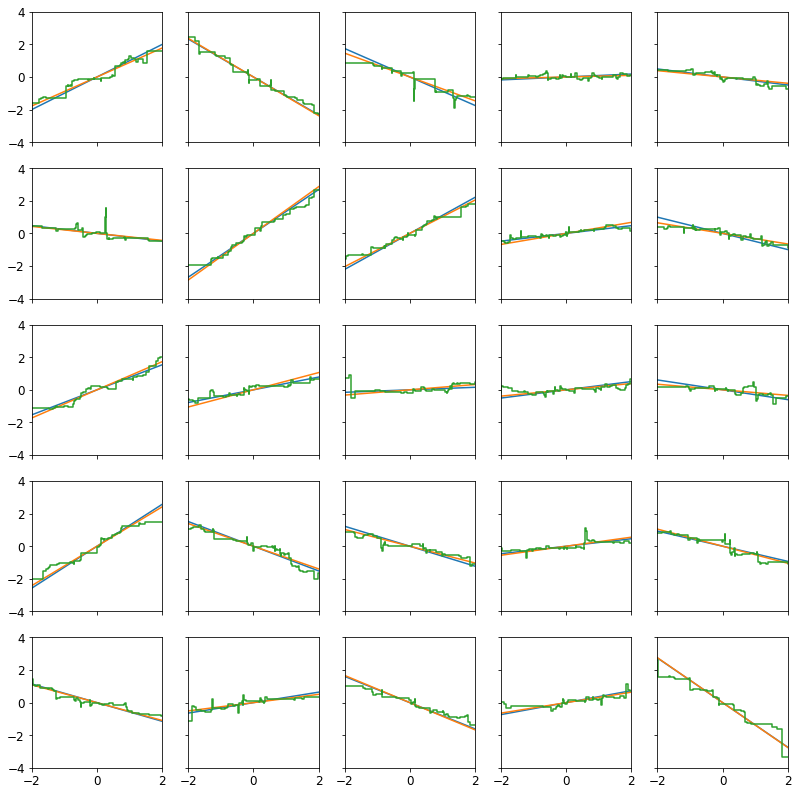

In [184]:
#Plotting everything
fig,axs=plt.subplots(bs,bs,sharex=True, sharey=True)
fig.set_figheight(15)
fig.set_figwidth(15)

for indx in range(0,len(beta)):
    i = math.floor(indx/bs)
    j = indx-i*bs
    sortedx = np.sort(x[:,indx])
    xs = np.array([min(sortedx),max(sortedx)])
    y_true = np.array(xs*beta[indx])
    y_hat = np.array(xs*beta_hat[indx])
    axs[i,j].plot(xs, y_true)
    axs[i,j].plot(xs, y_hat)
    axs[i,j].step(ebm_global.data(indx)['names'],np.append(ebm_global.data(indx)['scores'][0],ebm_global.data(indx)['scores']))
    axs[i,j].set_xlim(-2.0,2.0)
    axs[i,j].set_ylim(-badd*4,badd*4)
fig.subplots_adjust(left=0.2, bottom=0.2, right=0.9, top=0.9, wspace=0.2, hspace=0.2)

plt.show()

In [185]:
X_train.shape

(16000, 25)

In [192]:
import torch
import numpy as np
from torch.utils.data import TensorDataset, DataLoader

train_dataset = TensorDataset(torch.Tensor(X_train), torch.Tensor(Y_train)) 
test_dataset = TensorDataset(torch.Tensor(X_test), torch.Tensor(Y_test))

print(f"train_dataset: {len(train_dataset)}, test_dataset: {len(test_dataset)}")

train_dataset: 16000, test_dataset: 4000


In [193]:
train_dataset, val_dataset = torch.utils.data.random_split(
  train_dataset,
  [int(np.floor(len(train_dataset) * .8)),
   int(np.ceil(len(train_dataset) * .2))],
)
print(f"train_dataset: {len(train_dataset)}, val_dataset: {len(val_dataset)}")

train_dataloader = DataLoader(
  train_dataset,
  batch_size=config.batch_size,
  shuffle=True,
  num_workers=config.num_workers,
#   sampler=weighted_sampler,
)
val_dataloader = DataLoader(
  val_dataset,
  batch_size=config.batch_size * 5,
  shuffle=False,
  num_workers=config.num_workers,
)

train_dataset: 12800, val_dataset: 3200


In [194]:
next(iter(train_dataloader))

[tensor([[-0.1526, -0.0699,  0.0344,  ..., -2.4379,  0.4553,  0.2228],
         [ 0.8710, -0.1761, -0.5021,  ..., -0.2297, -0.1952,  0.4735],
         [ 0.7388, -1.3238, -0.0403,  ...,  1.2796, -0.6479,  0.7110],
         ...,
         [-1.1951,  2.2898,  0.5310,  ...,  0.3028, -0.5856,  1.1773],
         [ 0.5276, -1.0801, -0.6829,  ...,  1.2537, -2.2294, -0.9727],
         [-1.0439, -0.0601, -1.2034,  ..., -1.3291, -0.8596, -0.2314]]),
 tensor([27.7214, 21.0314, 27.0017,  ..., -2.2709, -7.6513, -3.3114])]

In [197]:
len(train_dataset[0][0])

25

In [199]:
model = NAM(
      config=config,
      name="NAMModel_LR",
      num_inputs=len(train_dataset[0][0]),
      num_units=get_num_units(config, train_dataloader)
)
model

/Users/amrmkayid/anaconda3/envs/nam/lib/python3.7/site-packages/torch/nn/init.py:162: UserWarning: mean is more than 2 std from [a, b] in nn.init.trunc_normal_. The distribution of values may be incorrect.
  return _no_grad_trunc_normal_(tensor, mean, std, a, b)


NAM(
  (feature_nns): Sequential(
    (FeatureNN_0): FeatureNN(
      (model): Sequential(
        (0): ExU(in_features=1, out_features=1000)
        (1): LinReLU(in_features=1000, out_features=64)
        (2): LinReLU(in_features=64, out_features=32)
        (3): LinReLU(in_features=32, out_features=1)
      )
    )
    (FeatureNN_1): FeatureNN(
      (model): Sequential(
        (0): ExU(in_features=1, out_features=1000)
        (1): LinReLU(in_features=1000, out_features=64)
        (2): LinReLU(in_features=64, out_features=32)
        (3): LinReLU(in_features=32, out_features=1)
      )
    )
    (FeatureNN_2): FeatureNN(
      (model): Sequential(
        (0): ExU(in_features=1, out_features=1000)
        (1): LinReLU(in_features=1000, out_features=64)
        (2): LinReLU(in_features=64, out_features=32)
        (3): LinReLU(in_features=32, out_features=1)
      )
    )
    (FeatureNN_3): FeatureNN(
      (model): Sequential(
        (0): ExU(in_features=1, out_features=1000)
   

In [200]:
loss_obj = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=config.lr)

In [201]:
for i in range(config.training_epochs):
        optimizer.zero_grad()
        for X, y, *w in train_dataloader:
            y_pred = model(X)
            loss = loss_obj(y_pred, y)
            loss.backward()
            optimizer.step()
            print(f'loss: {loss.item()}')

/Users/amrmkayid/anaconda3/envs/nam/lib/python3.7/site-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([1024])) that is different to the input size (torch.Size([1024, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


loss: 37910.98046875
loss: 3027.17333984375
loss: 1260.0426025390625
loss: 497.72894287109375
loss: 1086.264892578125
loss: 145.00889587402344
loss: 143.3607177734375
loss: 166.01918029785156
loss: 137.21466064453125
loss: 137.58963012695312
loss: 136.67327880859375
loss: 130.57212829589844
loss: 141.54693603515625


/Users/amrmkayid/anaconda3/envs/nam/lib/python3.7/site-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([512])) that is different to the input size (torch.Size([512, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


loss: 138.5167236328125
loss: 151.27325439453125
loss: 137.65972900390625
loss: 141.980224609375
loss: 139.1464385986328
loss: 136.0861053466797
loss: 129.47267150878906
loss: 128.93504333496094
loss: 158.31224060058594
loss: 136.73008728027344
loss: 132.42921447753906
loss: 132.38514709472656
loss: 147.32704162597656
loss: 141.46954345703125
loss: 143.9274444580078
loss: 139.38441467285156
loss: 124.92742156982422
loss: 147.96380615234375
loss: 145.59117126464844
loss: 142.50132751464844
loss: 130.53343200683594
loss: 150.8231201171875
loss: 129.20997619628906
loss: 142.363037109375
loss: 139.24720764160156
loss: 120.27325439453125
loss: 131.596923828125
loss: 139.44093322753906
loss: 138.36485290527344
loss: 139.15760803222656
loss: 139.71620178222656
loss: 131.7268829345703
loss: 134.58526611328125
loss: 144.710205078125
loss: 134.15142822265625
loss: 140.13255310058594
loss: 142.97377014160156
loss: 145.8238983154297
loss: 142.50445556640625
loss: 136.59844970703125
loss: 146.71826

In [186]:
import time

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix

from tqdm.notebook import tqdm


from sklearn import metrics
from sklearn import preprocessing
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report



from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import ExtraTreesClassifier

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, WeightedRandomSampler

In [187]:
from nam.config import defaults
from nam.data import NAMDataset
from nam.models import NAM, get_num_units

## Config

In [188]:
config = defaults()
config

namespace(device='cpu',
          output_dir='output',
          training_epochs=10,
          lr=0.01,
          batch_size=1024,
          hidden_sizes=[64, 32],
          activation='exu',
          optimizer='adam',
          dropout=0.5,
          feature_dropout=0.0,
          decay_rate=0.995,
          l2_regularization=0.0,
          output_regularization=0.0,
          num_basis_functions=1000,
          units_multiplier=2,
          num_units=64,
          data_split=1,
          seed=1377,
          cross_val=False,
          n_models=1,
          num_splits=3,
          fold_num=1,
          shuffle=True,
          regression=False,
          debug=False,
          use_dnn=False,
          patience=10,
          n_folds=5,
          num_workers=16)

## DATA

In [4]:
data = pd.read_csv('data/GALLUP.csv')
data

,WP16,wgt,country,income_2,WP1219,WP1220,year,weo_gdpc_con_ppp
0,4,1.800488,Israel,18042.771080,1.0,15.0,2016,32658.020
1,4,2.360024,Israel,12799.412740,1.0,15.0,2013,31369.909
2,8,1.463117,Israel,22448.936000,1.0,15.0,2015,32038.697
3,5,1.246618,Israel,16853.739740,1.0,15.0,2014,31844.204
4,8,1.800488,Israel,22206.487490,1.0,15.0,2016,32658.020
...,...,...,...,...,...,...,...,...
1340804,3,0.569955,Zimbabwe,566.020845,1.0,100.0,2017,2079.190
1340805,3,0.533722,Zimbabwe,453.127896,1.0,100.0,2014,2134.776
1340806,5,1.286156,Zimbabwe,0.000000,1.0,100.0,2011,1920.745
1340807,5,0.643078,Zimbabwe,2869.777740,1.0,100.0,2011,1920.745


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1340809 entries, 0 to 1340808
Data columns (total 8 columns):
 #   Column            Non-Null Count    Dtype  
---  ------            --------------    -----  
 0   WP16              1340809 non-null  int64  
 1   wgt               1340809 non-null  float64
 2   country           1340809 non-null  object 
 3   income_2          1340809 non-null  float64
 4   WP1219            1340808 non-null  float64
 5   WP1220            1340624 non-null  float64
 6   year              1340809 non-null  int64  
 7   weo_gdpc_con_ppp  1316687 non-null  float64
dtypes: float64(5), int64(2), object(1)
memory usage: 81.8+ MB


In [6]:
data.describe()

,WP16,wgt,income_2,WP1219,WP1220,year,weo_gdpc_con_ppp
count,1.340809e+06,1.340809e+06,1.340809e+06,1.340808e+06,1.340624e+06,1.340809e+06,1.316687e+06
mean,5.515844e+00,9.981441e-01,2.661370e+04,1.531649e+00,4.152368e+01,2.012821e+03,2.023897e+04
std,2.312987e+00,6.772548e-01,1.116962e+06,4.989975e-01,1.781361e+01,2.363612e+00,1.934277e+04
min,0.000000e+00,6.493207e-02,0.000000e+00,1.000000e+00,1.300000e+01,2.009000e+03,6.043400e+02
25%,4.000000e+00,4.892472e-01,4.311222e+03,1.000000e+00,2.700000e+01,2.011000e+03,5.190297e+03
50%,5.000000e+00,8.148008e-01,1.084338e+04,2.000000e+00,3.900000e+01,2.013000e+03,1.384583e+04
75%,7.000000e+00,1.307699e+00,2.694815e+04,2.000000e+00,5.400000e+01,2.015000e+03,3.174637e+04
max,1.000000e+01,7.637515e+00,8.980336e+08,2.000000e+00,1.010000e+02,2.017000e+03,1.457238e+05


In [7]:
data.WP16.value_counts()

5     304903
7     181094
6     170730
8     164172
4     144256
3     117753
2      64560
10     62924
9      60022
1      36923
0      33472
Name: WP16, dtype: int64

<AxesSubplot:xlabel='WP16', ylabel='count'>

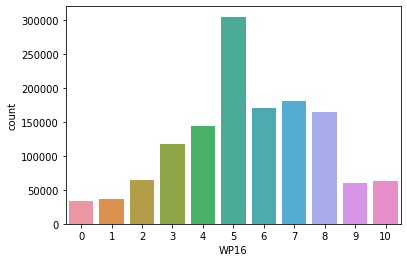

In [8]:
sns.countplot(x = 'WP16', data=data)

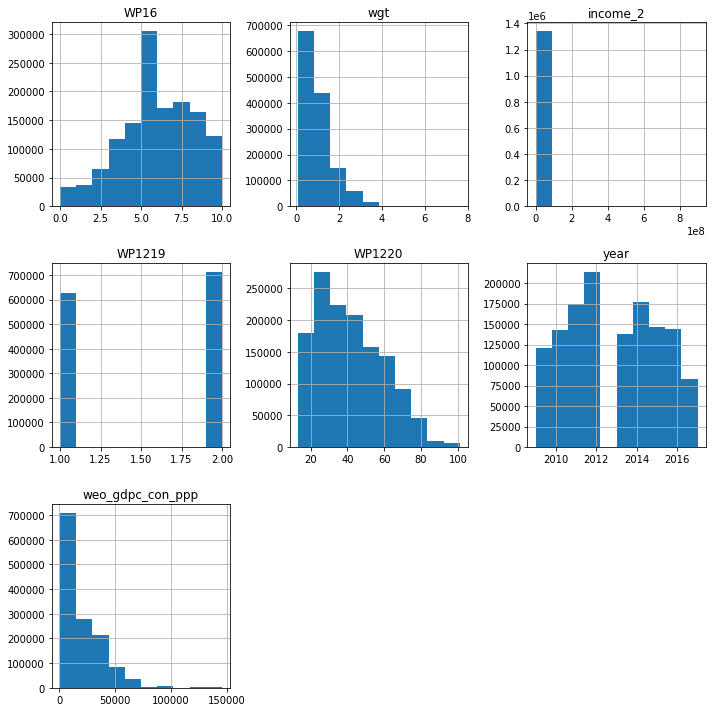

In [21]:
data.hist(figsize=(10,10))
plt.tight_layout()

### Correlations

<AxesSubplot:>

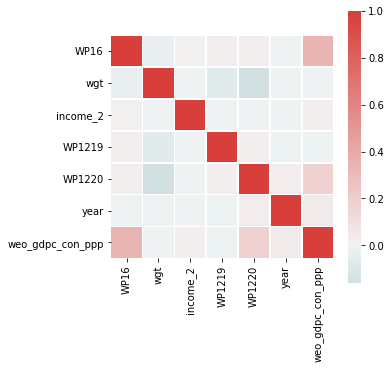

In [23]:
corr = data.corr()
f, ax = plt.subplots(figsize=(5, 5))
cmap = sns.diverging_palette(2000, 13, as_cmap=True)
sns.heatmap(corr, cmap=cmap, center=0,square=True, linewidths=.5)

### PaiPlots

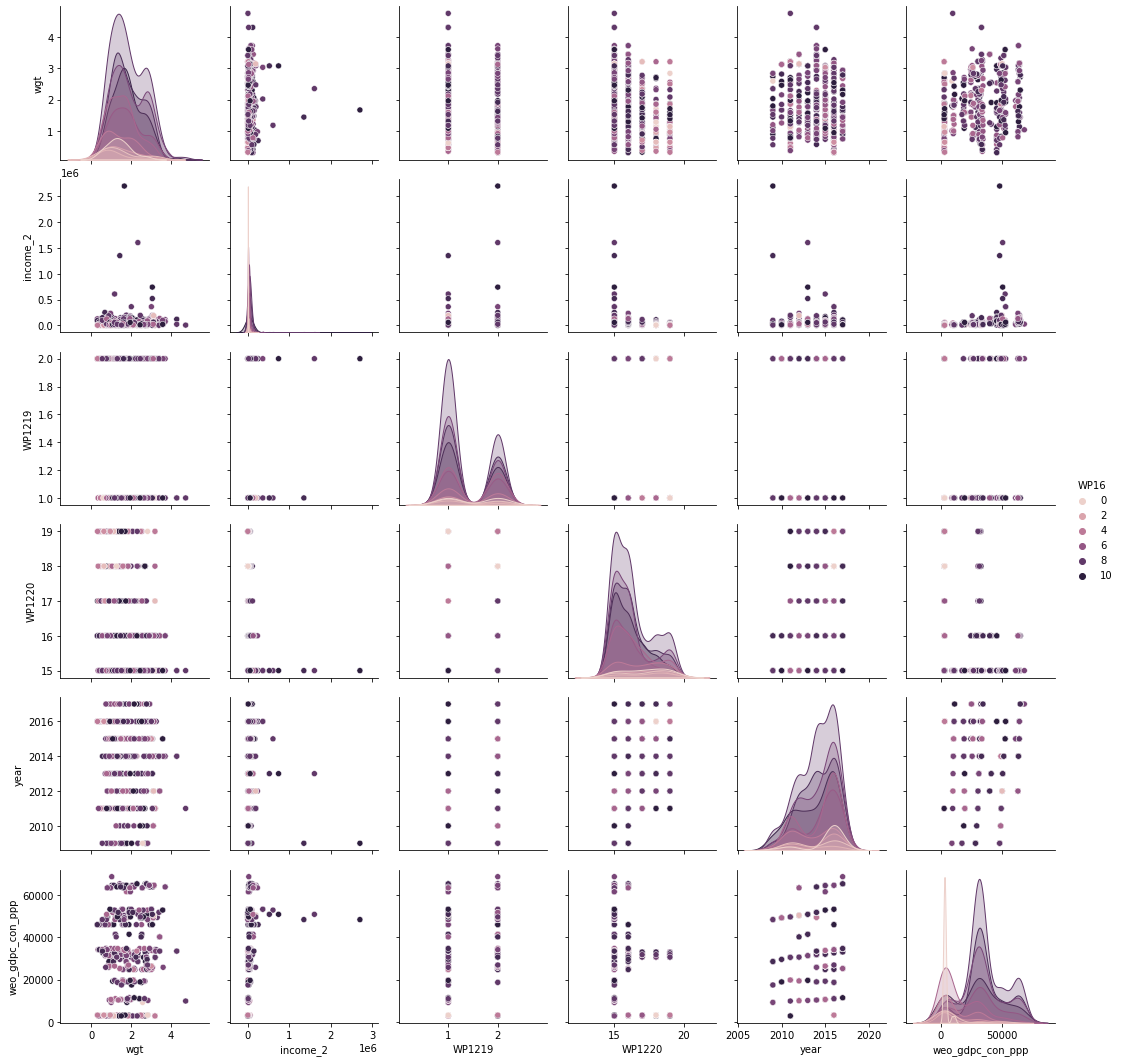

In [37]:
sns.pairplot(data[:1000], hue = 'WP16')

### Outliers

<AxesSubplot:>

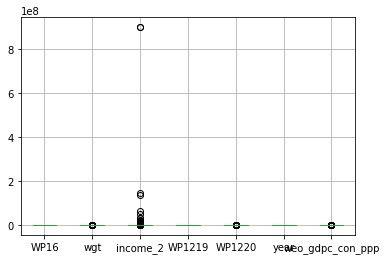

In [29]:
data.boxplot()

<AxesSubplot:>

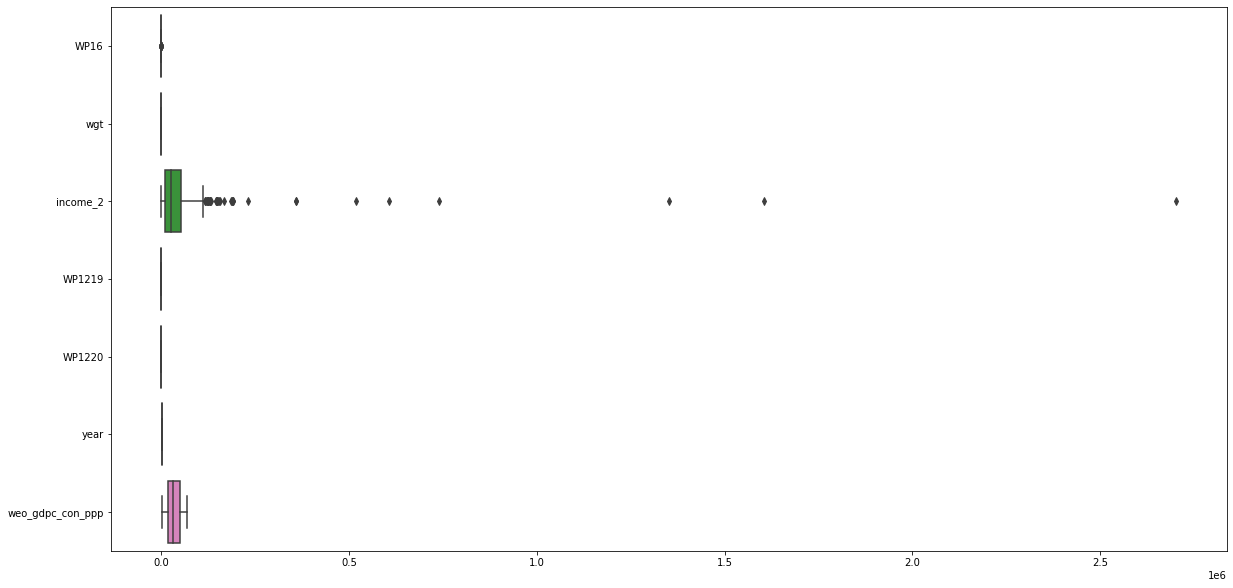

In [41]:
fig = plt.figure(figsize = (20,10))
ax = fig.gca()
sns.boxplot(data= data[500:1000], orient="h",  ax = ax)

## Remove NaNs

In [9]:
data = data.interpolate(method='linear', axis=0)

---
---
---

In [40]:
dataset = NAMDataset(
    config=config,
    csv_file=data, #'data/GALLUP.csv',
    features_columns = ["income_2", "WP1219", "WP1220", "weo_gdpc_con_ppp"],
    targets_column = ["WP16"],
    weights_column = ["wgt"],   
#     one_hot=True,
)
dataset

NAMDatasetSample(
	features=tensor([3.0974e+04, 2.0000e+00, 3.8000e+01, 1.6759e+04]), 
	targets=tensor([1.]), 
	weights=tensor([0.4565])
)

In [41]:
weighted_sampler = WeightedRandomSampler(
    weights=dataset.weights,
    num_samples=len(dataset),
    replacement=True
)

In [42]:
train_dataset, test_dataset = torch.utils.data.random_split(
  dataset,
  [int(np.floor(len(dataset) * .9)),
   int(np.ceil(len(dataset) * .1))],
)
print(f"train_dataset: {len(train_dataset)}, test_dataset: {len(test_dataset)}")

train_dataset, val_dataset = torch.utils.data.random_split(
  train_dataset,
  [int(np.floor(len(train_dataset) * .8)),
   int(np.ceil(len(train_dataset) * .2))],
)
print(f"train_dataset: {len(train_dataset)}, val_dataset: {len(val_dataset)}")

train_dataloader = DataLoader(
  train_dataset,
  batch_size=config.batch_size,
  shuffle=True,
  num_workers=config.num_workers,
#   sampler=weighted_sampler,
)
val_dataloader = DataLoader(
  val_dataset,
  batch_size=config.batch_size * 5,
  shuffle=False,
  num_workers=config.num_workers,
)

train_dataset: 1206728, test_dataset: 134081
train_dataset: 965382, val_dataset: 241346


In [43]:
next(iter(train_dataloader))

[tensor([[1.7930e+03, 2.0000e+00, 4.0000e+01, 5.2336e+03],
         [7.8890e+03, 2.0000e+00, 1.7000e+01, 2.6061e+03],
         [1.2793e+04, 2.0000e+00, 2.5000e+01, 1.0572e+03],
         ...,
         [7.4095e+03, 2.0000e+00, 2.5000e+01, 1.8411e+03],
         [9.4302e+03, 1.0000e+00, 3.0000e+01, 1.8411e+03],
         [1.4289e+04, 1.0000e+00, 4.2000e+01, 4.2492e+03]]),
 tensor([[ 7.],
         [ 0.],
         [10.],
         ...,
         [ 3.],
         [ 5.],
         [ 5.]]),
 tensor([[2.5051],
         [0.5674],
         [0.9002],
         ...,
         [2.6331],
         [0.4706],
         [0.8630]])]

In [44]:
features, targets, *weights = next(iter(train_dataloader))

---
---
---

In [52]:
model = NAM(
      config=config,
      name="NAMModel_GALLUP",
      num_inputs=len(dataset[0][0]),
      num_units=get_num_units(config, train_dataloader)
)
model

/Users/amrmkayid/anaconda3/envs/nam/lib/python3.7/site-packages/torch/nn/init.py:162: UserWarning: mean is more than 2 std from [a, b] in nn.init.trunc_normal_. The distribution of values may be incorrect.
  return _no_grad_trunc_normal_(tensor, mean, std, a, b)


NAM(
  (feature_nns): Sequential(
    (FeatureNN_0): FeatureNN(
      (model): Sequential(
        (0): ExU(in_features=1, out_features=1000)
        (1): LinReLU(in_features=1000, out_features=64)
        (2): LinReLU(in_features=64, out_features=32)
        (3): LinReLU(in_features=32, out_features=1)
      )
    )
    (FeatureNN_1): FeatureNN(
      (model): Sequential(
        (0): ExU(in_features=1, out_features=4)
        (1): LinReLU(in_features=4, out_features=64)
        (2): LinReLU(in_features=64, out_features=32)
        (3): LinReLU(in_features=32, out_features=1)
      )
    )
    (FeatureNN_2): FeatureNN(
      (model): Sequential(
        (0): ExU(in_features=1, out_features=148)
        (1): LinReLU(in_features=148, out_features=64)
        (2): LinReLU(in_features=64, out_features=32)
        (3): LinReLU(in_features=32, out_features=1)
      )
    )
    (FeatureNN_3): FeatureNN(
      (model): Sequential(
        (0): ExU(in_features=1, out_features=1000)
        (1)

In [53]:
features, targets, *weights = next(iter(train_dataloader))

In [61]:
model(features)

tensor([[      0.0000],
        [      0.0000],
        [      0.0000],
        ...,
        [   1612.4397],
        [ 405422.2188],
        [1220125.2500]], grad_fn=<AddBackward0>)

In [12]:
loss_obj = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=config.lr)

In [13]:
for i in range(config.training_epochs):
        optimizer.zero_grad()
        for X, y, *w in train_dataloader:
            y_pred = model(X)
            loss = loss_obj(y_pred, y)
            loss.backward()
            optimizer.step()
            print(f'loss: {loss.item()}')

loss: 3574734782464.0
loss: 111485878272.0
loss: 47233892352.0
loss: 106781220864.0
loss: 1066189952.0
loss: 34630424.0
loss: 19728906240.0
loss: 59250580.0
loss: 38.191280364990234
loss: 36.70461654663086
loss: 37.59029006958008
loss: 37.09481430053711
loss: 37.33030700683594
loss: 37.48571014404297
loss: 37.43302536010742
loss: 36.65161895751953
loss: 37.32002258300781
loss: 39.441959381103516
loss: 37.36842346191406
loss: 38.120323181152344
loss: 37.24638748168945
loss: 38.901832580566406
loss: 39.179893493652344
loss: 38.946495056152344
loss: 38.95313262939453
loss: 37.084842681884766
loss: 38.63157653808594
loss: 39.609825134277344
loss: 40.21871566772461
loss: 39.029876708984375
loss: 37.32095718383789
loss: 39.80905532836914
loss: 38.43172073364258
loss: 39.76947784423828
loss: 40.80961227416992
loss: 40.39934539794922
loss: 40.569759368896484
loss: 39.92286682128906
loss: 40.437950134277344
loss: 40.69986343383789
loss: 39.90713119506836
loss: 40.525997161865234
loss: 39.911907

loss: 84.72490692138672
loss: 82.74044036865234
loss: 86.01213073730469
loss: 88.0633544921875
loss: 85.77327728271484
loss: 86.98686218261719
loss: 88.22852325439453
loss: 88.25991821289062
loss: 85.6612319946289
loss: 87.60079193115234
loss: 87.48625183105469
loss: 88.21771240234375
loss: 85.47509002685547
loss: 89.73619079589844
loss: 88.48993682861328
loss: 89.97142028808594
loss: 88.57669830322266
loss: 91.07524108886719
loss: 89.53038024902344
loss: 91.3406982421875
loss: 91.34941101074219
loss: 90.37006378173828
loss: 90.9813461303711
loss: 88.6838150024414
loss: 90.12881469726562
loss: 89.02037811279297
loss: 90.33599090576172
loss: 90.85624694824219
loss: 93.33700561523438
loss: 93.35098266601562
loss: 88.78829193115234
loss: 91.42804718017578
loss: 92.23898315429688
loss: 92.30879974365234
loss: 90.76963806152344
loss: 93.70146942138672
loss: 92.06399536132812
loss: 93.19420623779297
loss: 91.05093383789062
loss: 92.51411437988281
loss: 95.00755310058594
loss: 91.517547607421

loss: 155.91241455078125
loss: 156.90219116210938
loss: 158.75582885742188
loss: 155.85462951660156
loss: 160.56497192382812
loss: 156.43031311035156
loss: 157.41305541992188
loss: 160.30355834960938
loss: 158.27886962890625
loss: 156.8771209716797
loss: 161.56411743164062
loss: 157.06060791015625
loss: 158.40489196777344
loss: 159.39584350585938
loss: 163.76625061035156
loss: 156.34420776367188
loss: 160.29080200195312
loss: 161.13229370117188
loss: 162.9802703857422
loss: 161.1189422607422
loss: 160.443115234375
loss: 160.89352416992188
loss: 164.22634887695312
loss: 161.2825927734375
loss: 162.4498748779297
loss: 164.36553955078125
loss: 162.25811767578125
loss: 165.76071166992188
loss: 165.39016723632812
loss: 164.28094482421875
loss: 164.17361450195312
loss: 160.6943817138672
loss: 164.64447021484375
loss: 163.8174285888672
loss: 165.3560791015625
loss: 164.72596740722656
loss: 167.107177734375
loss: 164.19757080078125
loss: 166.47506713867188
loss: 165.12628173828125
loss: 166.37

KeyboardInterrupt: 